# Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

# Todo List
- Add several dense layers after convolutional layers
- Play with learning rate and batch size

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import pickle
import helper
import os

dataset_dir = 'DataSet/'

In [2]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


# Import Data

In [3]:
count = 0
for filename in os.listdir(dataset_dir):
    if filename.endswith("test_set.pkl") or filename.endswith("predict.pkl") or filename.endswith("debug.pkl"):
        continue
    if filename.endswith(".pkl"): 
        df = pd.read_pickle(os.path.join(dataset_dir, filename))
        
        if count == 0:
            raw_df = df
        else:
            raw_df = raw_df.append(df, ignore_index=True)
            
        print('File: {}, DataSet Length: {}'.format(os.path.join(dataset_dir, filename), len(df)))
        count += 1
    else:
        continue
print('Total Length: {}'.format(len(raw_df)))

File: DataSet/2018-07-13_18-39-56_0.pkl, DataSet Length: 500
File: DataSet/2018-07-13_18-43-51_0.pkl, DataSet Length: 500
File: DataSet/2018-07-13_18-46-04_1.pkl, DataSet Length: 500
File: DataSet/2018-07-13_18-47-58_2.pkl, DataSet Length: 500
File: DataSet/2018-07-13_18-49-54_3.pkl, DataSet Length: 500
File: DataSet/2018-07-13_18-52-16_4.pkl, DataSet Length: 500
File: DataSet/2018-07-13_18-54-29_5.pkl, DataSet Length: 500
File: DataSet/2018-07-13_18-56-38_6.pkl, DataSet Length: 500
File: DataSet/2018-07-13_18-58-30_7.pkl, DataSet Length: 500
File: DataSet/2018-07-13_19-00-21_8.pkl, DataSet Length: 500
File: DataSet/2018-07-13_19-02-36_9.pkl, DataSet Length: 500
File: DataSet/2018-07-13_19-04-42_10.pkl, DataSet Length: 500
File: DataSet/2018-07-13_19-06-38_11.pkl, DataSet Length: 500
File: DataSet/2018-07-13_19-08-49_12.pkl, DataSet Length: 500
File: DataSet/2018-07-13_19-10-48_13.pkl, DataSet Length: 500
File: DataSet/2018-07-13_19-12-43_14.pkl, DataSet Length: 500
File: DataSet/2018-

In [4]:
data_width = len(raw_df['data'][0])

# Data Preprocessing

#### Filter out key counts less than threshold value

In [8]:
import collections
import matplotlib.pyplot as plt

key_count = collections.Counter(raw_df['key']) # List of key count in dataset

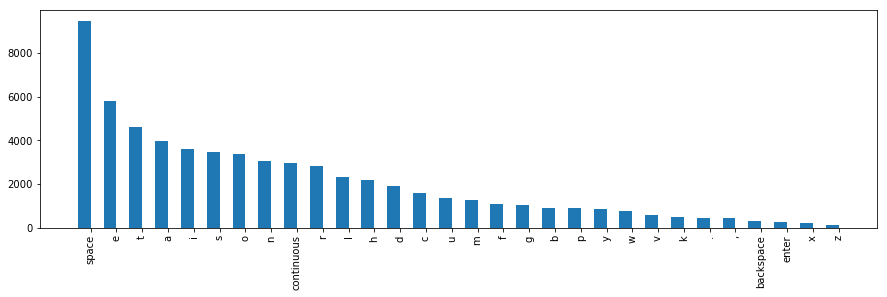

<bound method Counter.most_common of Counter({'space': 9466, 'e': 5811, 't': 4596, 'a': 3979, 'i': 3602, 's': 3452, 'o': 3392, 'n': 3049, 'continuous': 2949, 'r': 2832, 'l': 2343, 'h': 2164, 'd': 1916, 'c': 1583, 'u': 1368, 'm': 1293, 'f': 1070, 'g': 1050, 'b': 907, 'p': 883, 'y': 855, 'w': 788, 'v': 601, 'k': 493, '.': 464, ',': 434, 'backspace': 320, 'enter': 271, 'x': 221, 'z': 147, '-': 126, 'shift': 126, '0': 126, "'": 122, 'j': 121, 'q': 100, '1': 69, '2': 69, 'ctrl_l': 60, ';': 40, '9': 39, 'down': 38, 'delete': 38, '3': 37, '5': 31, '/': 29, 'esc': 17, 'left': 16, '7': 15, '8': 15, '4': 14, '6': 14, 'up': 10, 'right': 8, '=': 4, 'tab': 4, '`': 1})>

In [9]:
helper.plot_key_hist(key_count.most_common())
key_count.most_common

In [10]:
# Maximize DataSet Size By Finding Optimal Threshold
max_data_size, max_class_cnt, threshold_max = helper.get_optimized_threshold(key_count)
print('Max Data Size: {}, Class Count: {}, Threshold: {}'.format(max_data_size, max_class_cnt, threshold_max))

# OR, Manually define threshold
#threshold_max = 3048

Max Data Size: 28320, Class Count: 10, Threshold: 2831


#### Get Key Classes

In [11]:
# Get list of keys with counts greater than threshold
threshold = threshold_max
min_thresh_keys = [key for key, count in zip(key_count.keys(), key_count.values()) if count > threshold]

# Save list of key classes to pickle
pickle.dump(min_thresh_keys, open(os.path.join(dataset_dir, "key_classes.p"), "wb"))

#### Filter Data Set

In [12]:
min_thresh_df = raw_df[raw_df['key'].isin(min_thresh_keys)] # Filter dataframe to only include keys > threshold

In [13]:
def trim_max_thresh(grouped_class):
    return grouped_class.sample(threshold)

In [14]:
# Keep same number of samples in each class by throwing away everything past the threshold
df = min_thresh_df.groupby(['key']).apply(trim_max_thresh)

#### Plot truncated data

In [15]:
truncated_count = collections.Counter(df['key'])

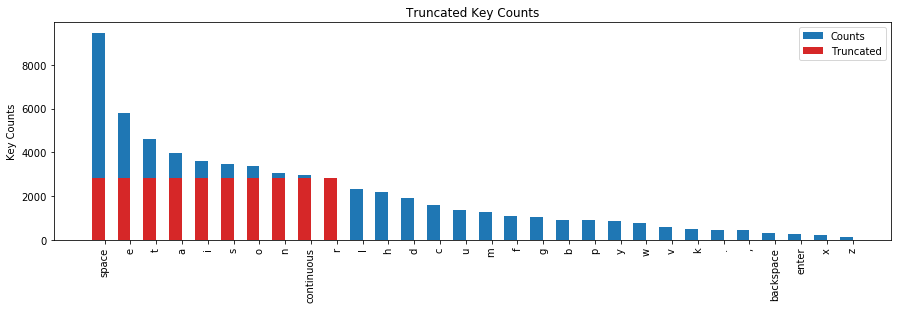

In [16]:
helper.plot_trunc_key_cnt(key_count.most_common(), truncated_count.most_common())

#### Shuffle data

In [17]:
df = df.sample(frac=1).reset_index(drop=True)

### One Hot Encode Classes
<img src="assets/one_hot_encoding.jpg" style="width: 200px;"/>

In [18]:
n_classes = len(set(df['key']))

labels_str = [str(key) for key in df['key']]
lb = preprocessing.LabelBinarizer() # Create encoder
lb.fit(list(set(labels_str)))
labels = lb.transform(labels_str)

In [19]:
lb.classes_

array(['a', 'continuous', 'e', 'i', 'n', 'o', 'r', 's', 'space', 't'],
      dtype='<U10')

In [20]:
# Save label set
pickle.dump(lb.classes_, open(os.path.join(dataset_dir, 'labels.p'), "wb"))

### Cross Validation: Training, Validation, and Test Sets

In [21]:
input_data = df['data'].values
input_data = np.stack(input_data, axis=0)

In [22]:
from sklearn.model_selection import train_test_split
train_features, temp_features, train_labels, temp_labels = train_test_split(input_data, labels, test_size=0.1, random_state=42)
test_features, valid_features, test_labels, valid_labels = train_test_split(temp_features, temp_labels, test_size=0.5, random_state=42)

### Normalize Data
Normalization should be performed on the training set. All other test sets should be normalized to parameters fit from the training set's scaler.

#### Normalize Training Set and Fit Scaler

In [23]:
"""
Careful with MinMaxScaler. 
You specifically wan't to use the fit then transform or fit_transform function on the training set only.
On any of the test cross validation sets or prediction data, you DON'T want to fit() or fit_transform().
This would reset the fit of the scaler that we fit with the training set data.
Use the transform() function on the test sets.
"""
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
scaler.fit(train_features) # Compute the minimum and maximum to be used for later scaling.
#train_features = scaler.fit_transform(train_features)
train_features = scaler.transform(train_features)

C:\Users\stephen\AppData\Local\conda\conda\envs\tfgpu1.1\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int16 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [24]:
train_features.shape

(25479, 10240)

In [25]:
# Reshape for 1 channel of audio data
train_features = train_features.reshape((train_features.shape[0], train_features.shape[1], 1))
# labels = labels.reshape((labels.shape[0], labels.shape[1], 1))
train_features.shape

(25479, 10240, 1)

In [26]:
# Save scaler for later scaling on test sets. scaler.fit() saved the min max values
pickle.dump(scaler, open(os.path.join(dataset_dir, 'scaler.p'), "wb"))

#### Normalize Validation Set

In [27]:
valid_features = scaler.transform(valid_features) # Don't use fit_transform() on test sets, use transform()

# Reshape for 1 channel of audio data
valid_features = valid_features.reshape((valid_features.shape[0], valid_features.shape[1], 1))

# Define Network

### Input

In [28]:
def model_inputs(data_width, n_classes):
    """
    Create the model inputs
    :param data_width: The total number of samples in the recorded data point
    :param n_classes: Number of Classes
    :return: Tuple of (tensor of input audio data, key press labels, learning rate, keep_prob)
    """
    # TODO: Add audio channels to input
    
    with tf.name_scope("Inputs"):
        audio_inputs = tf.placeholder(tf.float32, [None, data_width, 1], name='inputs')
    with tf.name_scope("Targets"):
        key_labels = tf.placeholder(tf.float32, [None, n_classes], name='labels')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    keep_prob = tf.placeholder(tf.float32, name='keep_probability')

    return audio_inputs, key_labels, learning_rate, keep_prob

### Get Batches

In [29]:
def get_batches(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

### Network

In [30]:
def network(X, keep_prob, n_classes):
    """
    Create the network
    :param X: Tensor of input recording(s)
    :param keep_prob: Tensor for the keep probability
    :param n_classes: Number of Classes
    :return: Tuple of (tensor output of the classifier, tensor logits of the classifier)
    """    
    # Hyperparameters
    alpha = 0.2
    h_dim = 32
    
    #print("X: {}".format(X.shape))
     
    with tf.name_scope("Hidden_Layer1"):
        #h1 = tf.layers.dense(X, h_dim, activation=None)
        h1 = tf.layers.conv1d(X, h_dim, 200, 10, 'same', activation=None)
        h1 = tf.layers.max_pooling1d(h1, 5, 2, 'same')
        h1 = tf.nn.dropout(h1, keep_prob) # Regularization
        h1 = tf.maximum(h1*alpha, h1) # Leaky ReLu
        h1 = tf.layers.batch_normalization(h1)
        
    #print("h1: {}".format(h1.shape))

    with tf.name_scope("Hidden_Layer2"):
        #h2 = tf.layers.dense(h1, h_dim, activation=None)
        h2 = tf.layers.conv1d(h1, h_dim*2, 50, 5, 'same', activation=None)
        #h2 = tf.layers.maxpool2d(h2, 5, 2, 'same')
        h2 = tf.nn.dropout(h2, keep_prob) # Regularization        
        h2 = tf.maximum(h2*alpha, h2) # Leaky ReLu
        h2 = tf.layers.batch_normalization(h2)
        
    #print("h2: {}".format(h2.shape))

    with tf.name_scope("Hidden_Layer3"):
        #h3 = tf.layers.dense(h2, h_dim, activation=None)
        h3 = tf.layers.conv1d(h2, h_dim*3, 20, 2, 'same', activation=None)
        #h3 = tf.layers.maxpool2d(h3, 3, 2, 'same')
        h3 = tf.nn.dropout(h3, keep_prob) # Regularization
        h3 = tf.maximum(h3*alpha, h3) # Leaky ReLu
        h3 = tf.layers.batch_normalization(h3)
        
    with tf.name_scope("Hidden_Layer4"):
        h4 = tf.layers.conv1d(h3, h_dim*4, 10, 1, 'same', activation=None)
        h4 = tf.nn.dropout(h4, keep_prob) # Regularization
        h4 = tf.maximum(h4*alpha, h4) # Leaky ReLu
        h4 = tf.layers.batch_normalization(h4)
    
    
    
    with tf.name_scope("Output"):
        flat_dim = int(h4.get_shape()[1])*int(h4.get_shape()[2])
        flat = tf.reshape(h4, [-1, flat_dim])
        #print("flat: {}".format(flat.shape))
        logits = tf.layers.dense(flat, n_classes, activation=None, name='logits')
        #print("logits: {}".format(logits.shape))
        #out = tf.nn.softmax(logits, name='softmax_out')

    return logits

### Show Stats

In [31]:
def print_stats(session, feature_batch, label_batch, cost, accuracy, esi):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    : esi: Epochs since the last improvement
    """
    with tf.name_scope("Validation_Stats"):
        valid_trunc_len = min(1000, len(valid_features))
        train_trunc_len = min(1000, len(train_features))
        
        validation_loss = session.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.0})
        validation_accuracy = session.run(accuracy, feed_dict={x: valid_features[:valid_trunc_len], y: valid_labels[:valid_trunc_len], keep_prob: 1.0})
        train_accuracy = session.run(accuracy, feed_dict={x: train_features[:train_trunc_len], y: train_labels[:train_trunc_len], keep_prob: 1.0})
        print("Train Accuracy: {0:0.4f}, Validation Accuracy: {1:0.4f}, Validation Loss: {2:0.4f}, ESI: {3}".format(train_accuracy, validation_accuracy, validation_loss, esi))
        return validation_accuracy

### Build Neural Network

In [32]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x, y, learn_rate, keep_prob = model_inputs(data_width, n_classes)

#Model
logits = network(x, keep_prob, n_classes)

with tf.name_scope("Cost"):
    # Cost and Optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y, name='loss'), name='cost')
    
with tf.name_scope("Train"):
    optimizer = tf.train.AdamOptimizer(learn_rate, name='optimizer').minimize(cost)

with tf.name_scope("Accuracy"):
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1), name='prediction')
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
    
predicted = tf.nn.softmax(logits, name='predicted')

### Write out the graph for TensorBoard

In [33]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    file_writer = tf.summary.FileWriter('./logs/2', sess.graph)

### Hyperparameters

In [34]:
epochs = 5000
batch_size = 16
keep_probability = 0.40
learning_rate = 0.0001

# Train Neural Network

In [35]:
# Accuracy to beat (Min of 3 classes)
print("{:.3}%".format((1/n_classes)*100))

10.0%


In [36]:
max_validation_accuracy = 0.0
epochs_since_improvement = 0
saver = tf.train.Saver()
with tf.Session() as sess:
    # Initialize the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        for batch_features, batch_labels in get_batches(train_features, train_labels, batch_size):
            sess.run(optimizer, feed_dict={x: batch_features, 
                                           y: batch_labels, 
                                           learn_rate: learning_rate, 
                                           keep_prob: keep_probability})
        if epoch % 1 == 0:
            print('Epoch {}: '.format(epoch), end='')
            validation_accuracy = print_stats(sess, batch_features, batch_labels, cost, accuracy, epochs_since_improvement)         
        
            if validation_accuracy > max_validation_accuracy:
                max_validation_accuracy = validation_accuracy
                epochs_since_improvement = 0
                saver.save(sess, "checkpoints/model.ckpt")
            else:
                epochs_since_improvement += 1

Epoch 0: Train Accuracy: 0.1020, Validation Accuracy: 0.1050, Validation Loss: 2.2972, ESI: 0
Epoch 1: Train Accuracy: 0.1020, Validation Accuracy: 0.1040, Validation Loss: 2.2926, ESI: 0
Epoch 2: Train Accuracy: 0.1220, Validation Accuracy: 0.1030, Validation Loss: 2.3000, ESI: 1
Epoch 3: Train Accuracy: 0.0910, Validation Accuracy: 0.1000, Validation Loss: 2.2978, ESI: 2
Epoch 4: Train Accuracy: 0.0910, Validation Accuracy: 0.1010, Validation Loss: 2.2949, ESI: 3
Epoch 5: Train Accuracy: 0.0910, Validation Accuracy: 0.1010, Validation Loss: 2.2959, ESI: 4
Epoch 6: Train Accuracy: 0.0910, Validation Accuracy: 0.1010, Validation Loss: 2.2962, ESI: 5
Epoch 7: Train Accuracy: 0.0910, Validation Accuracy: 0.1010, Validation Loss: 2.2959, ESI: 6
Epoch 8: Train Accuracy: 0.0910, Validation Accuracy: 0.1010, Validation Loss: 2.2949, ESI: 7
Epoch 9: Train Accuracy: 0.1020, Validation Accuracy: 0.0770, Validation Loss: 2.3146, ESI: 8
Epoch 10: Train Accuracy: 0.0910, Validation Accuracy: 0.101

Epoch 86: Train Accuracy: 0.2320, Validation Accuracy: 0.2110, Validation Loss: 1.6908, ESI: 0
Epoch 87: Train Accuracy: 0.2480, Validation Accuracy: 0.2330, Validation Loss: 1.6614, ESI: 0
Epoch 88: Train Accuracy: 0.2530, Validation Accuracy: 0.2440, Validation Loss: 1.6506, ESI: 0
Epoch 89: Train Accuracy: 0.2690, Validation Accuracy: 0.2580, Validation Loss: 1.5920, ESI: 0
Epoch 90: Train Accuracy: 0.2730, Validation Accuracy: 0.2540, Validation Loss: 1.6128, ESI: 0
Epoch 91: Train Accuracy: 0.2730, Validation Accuracy: 0.2630, Validation Loss: 1.6197, ESI: 1
Epoch 92: Train Accuracy: 0.2780, Validation Accuracy: 0.2730, Validation Loss: 1.6120, ESI: 0
Epoch 93: Train Accuracy: 0.2960, Validation Accuracy: 0.2770, Validation Loss: 1.6247, ESI: 0
Epoch 94: Train Accuracy: 0.3080, Validation Accuracy: 0.3100, Validation Loss: 1.5170, ESI: 0
Epoch 95: Train Accuracy: 0.3200, Validation Accuracy: 0.3090, Validation Loss: 1.5628, ESI: 0
Epoch 96: Train Accuracy: 0.3080, Validation Accur

Epoch 172: Train Accuracy: 0.4690, Validation Accuracy: 0.4410, Validation Loss: 0.9218, ESI: 3
Epoch 173: Train Accuracy: 0.4500, Validation Accuracy: 0.4210, Validation Loss: 0.9414, ESI: 0
Epoch 174: Train Accuracy: 0.4600, Validation Accuracy: 0.4240, Validation Loss: 0.9450, ESI: 1
Epoch 175: Train Accuracy: 0.4590, Validation Accuracy: 0.4270, Validation Loss: 0.9273, ESI: 2
Epoch 176: Train Accuracy: 0.4540, Validation Accuracy: 0.4300, Validation Loss: 0.9051, ESI: 3
Epoch 177: Train Accuracy: 0.4520, Validation Accuracy: 0.4110, Validation Loss: 0.9838, ESI: 4
Epoch 178: Train Accuracy: 0.4570, Validation Accuracy: 0.4230, Validation Loss: 0.9407, ESI: 5
Epoch 179: Train Accuracy: 0.4540, Validation Accuracy: 0.4230, Validation Loss: 0.9147, ESI: 6
Epoch 180: Train Accuracy: 0.4580, Validation Accuracy: 0.4380, Validation Loss: 0.9323, ESI: 7
Epoch 181: Train Accuracy: 0.4650, Validation Accuracy: 0.4350, Validation Loss: 0.8926, ESI: 8
Epoch 182: Train Accuracy: 0.4570, Valid

Epoch 258: Train Accuracy: 0.5170, Validation Accuracy: 0.4650, Validation Loss: 0.7877, ESI: 1
Epoch 259: Train Accuracy: 0.5070, Validation Accuracy: 0.4630, Validation Loss: 0.7893, ESI: 2
Epoch 260: Train Accuracy: 0.5200, Validation Accuracy: 0.4860, Validation Loss: 0.7353, ESI: 3
Epoch 261: Train Accuracy: 0.5120, Validation Accuracy: 0.4780, Validation Loss: 0.7423, ESI: 0
Epoch 262: Train Accuracy: 0.5200, Validation Accuracy: 0.4730, Validation Loss: 0.7275, ESI: 1
Epoch 263: Train Accuracy: 0.5260, Validation Accuracy: 0.4850, Validation Loss: 0.7688, ESI: 2
Epoch 264: Train Accuracy: 0.5160, Validation Accuracy: 0.4780, Validation Loss: 0.7011, ESI: 3
Epoch 265: Train Accuracy: 0.5180, Validation Accuracy: 0.4690, Validation Loss: 0.6922, ESI: 4
Epoch 266: Train Accuracy: 0.5150, Validation Accuracy: 0.4730, Validation Loss: 0.7180, ESI: 5
Epoch 267: Train Accuracy: 0.5150, Validation Accuracy: 0.4670, Validation Loss: 0.7600, ESI: 6
Epoch 268: Train Accuracy: 0.5170, Valid

Epoch 428: Train Accuracy: 0.5490, Validation Accuracy: 0.5020, Validation Loss: 0.5520, ESI: 4
Epoch 429: Train Accuracy: 0.5520, Validation Accuracy: 0.5090, Validation Loss: 0.4972, ESI: 5
Epoch 430: Train Accuracy: 0.5490, Validation Accuracy: 0.5060, Validation Loss: 0.5338, ESI: 6
Epoch 431: Train Accuracy: 0.5450, Validation Accuracy: 0.5060, Validation Loss: 0.4874, ESI: 7
Epoch 432: Train Accuracy: 0.5530, Validation Accuracy: 0.5060, Validation Loss: 0.4960, ESI: 8
Epoch 433: Train Accuracy: 0.5490, Validation Accuracy: 0.5110, Validation Loss: 0.4920, ESI: 9
Epoch 434: Train Accuracy: 0.5480, Validation Accuracy: 0.5110, Validation Loss: 0.5061, ESI: 10
Epoch 435: Train Accuracy: 0.5480, Validation Accuracy: 0.5120, Validation Loss: 0.5377, ESI: 11
Epoch 436: Train Accuracy: 0.5530, Validation Accuracy: 0.5090, Validation Loss: 0.5201, ESI: 12
Epoch 437: Train Accuracy: 0.5450, Validation Accuracy: 0.5030, Validation Loss: 0.5004, ESI: 13
Epoch 438: Train Accuracy: 0.5510, V

Epoch 513: Train Accuracy: 0.5680, Validation Accuracy: 0.5280, Validation Loss: 0.4542, ESI: 3
Epoch 514: Train Accuracy: 0.5720, Validation Accuracy: 0.5220, Validation Loss: 0.4662, ESI: 4
Epoch 515: Train Accuracy: 0.5720, Validation Accuracy: 0.5260, Validation Loss: 0.4685, ESI: 5
Epoch 516: Train Accuracy: 0.5600, Validation Accuracy: 0.5310, Validation Loss: 0.4561, ESI: 6
Epoch 517: Train Accuracy: 0.5560, Validation Accuracy: 0.5210, Validation Loss: 0.4549, ESI: 7
Epoch 518: Train Accuracy: 0.5640, Validation Accuracy: 0.5180, Validation Loss: 0.4599, ESI: 8
Epoch 519: Train Accuracy: 0.5640, Validation Accuracy: 0.5210, Validation Loss: 0.4891, ESI: 9
Epoch 520: Train Accuracy: 0.5700, Validation Accuracy: 0.5240, Validation Loss: 0.4605, ESI: 10
Epoch 521: Train Accuracy: 0.5600, Validation Accuracy: 0.5280, Validation Loss: 0.4704, ESI: 11
Epoch 522: Train Accuracy: 0.5630, Validation Accuracy: 0.5250, Validation Loss: 0.4439, ESI: 12
Epoch 523: Train Accuracy: 0.5630, Va

Epoch 598: Train Accuracy: 0.5750, Validation Accuracy: 0.5150, Validation Loss: 0.4368, ESI: 88
Epoch 599: Train Accuracy: 0.5770, Validation Accuracy: 0.5320, Validation Loss: 0.4442, ESI: 89
Epoch 600: Train Accuracy: 0.5730, Validation Accuracy: 0.5220, Validation Loss: 0.4408, ESI: 90
Epoch 601: Train Accuracy: 0.5820, Validation Accuracy: 0.5360, Validation Loss: 0.4420, ESI: 91
Epoch 602: Train Accuracy: 0.5750, Validation Accuracy: 0.5300, Validation Loss: 0.4370, ESI: 92
Epoch 603: Train Accuracy: 0.5900, Validation Accuracy: 0.5430, Validation Loss: 0.4115, ESI: 93
Epoch 604: Train Accuracy: 0.5830, Validation Accuracy: 0.5340, Validation Loss: 0.4235, ESI: 0
Epoch 605: Train Accuracy: 0.5790, Validation Accuracy: 0.5350, Validation Loss: 0.4192, ESI: 1
Epoch 606: Train Accuracy: 0.5810, Validation Accuracy: 0.5400, Validation Loss: 0.4253, ESI: 2
Epoch 607: Train Accuracy: 0.5830, Validation Accuracy: 0.5350, Validation Loss: 0.4099, ESI: 3
Epoch 608: Train Accuracy: 0.5760,

Epoch 683: Train Accuracy: 0.5850, Validation Accuracy: 0.5270, Validation Loss: 0.4029, ESI: 6
Epoch 684: Train Accuracy: 0.5870, Validation Accuracy: 0.5350, Validation Loss: 0.3976, ESI: 7
Epoch 685: Train Accuracy: 0.5890, Validation Accuracy: 0.5340, Validation Loss: 0.4170, ESI: 8
Epoch 686: Train Accuracy: 0.5910, Validation Accuracy: 0.5370, Validation Loss: 0.3870, ESI: 9
Epoch 687: Train Accuracy: 0.5860, Validation Accuracy: 0.5260, Validation Loss: 0.3964, ESI: 10
Epoch 688: Train Accuracy: 0.5840, Validation Accuracy: 0.5300, Validation Loss: 0.4111, ESI: 11
Epoch 689: Train Accuracy: 0.5950, Validation Accuracy: 0.5440, Validation Loss: 0.3823, ESI: 12
Epoch 690: Train Accuracy: 0.5960, Validation Accuracy: 0.5500, Validation Loss: 0.3992, ESI: 13
Epoch 691: Train Accuracy: 0.5900, Validation Accuracy: 0.5330, Validation Loss: 0.3871, ESI: 0
Epoch 692: Train Accuracy: 0.5850, Validation Accuracy: 0.5320, Validation Loss: 0.4197, ESI: 1
Epoch 693: Train Accuracy: 0.5950, V

Epoch 768: Train Accuracy: 0.6010, Validation Accuracy: 0.5380, Validation Loss: 0.4018, ESI: 55
Epoch 769: Train Accuracy: 0.5980, Validation Accuracy: 0.5500, Validation Loss: 0.4024, ESI: 56
Epoch 770: Train Accuracy: 0.6120, Validation Accuracy: 0.5440, Validation Loss: 0.3982, ESI: 57
Epoch 771: Train Accuracy: 0.6060, Validation Accuracy: 0.5440, Validation Loss: 0.3797, ESI: 58
Epoch 772: Train Accuracy: 0.5940, Validation Accuracy: 0.5480, Validation Loss: 0.3989, ESI: 59
Epoch 773: Train Accuracy: 0.5900, Validation Accuracy: 0.5400, Validation Loss: 0.3905, ESI: 60
Epoch 774: Train Accuracy: 0.6010, Validation Accuracy: 0.5430, Validation Loss: 0.3801, ESI: 61
Epoch 775: Train Accuracy: 0.5840, Validation Accuracy: 0.5440, Validation Loss: 0.4028, ESI: 62
Epoch 776: Train Accuracy: 0.5930, Validation Accuracy: 0.5480, Validation Loss: 0.3807, ESI: 63
Epoch 777: Train Accuracy: 0.6120, Validation Accuracy: 0.5600, Validation Loss: 0.3703, ESI: 64
Epoch 778: Train Accuracy: 0.6

Epoch 853: Train Accuracy: 0.6110, Validation Accuracy: 0.5560, Validation Loss: 0.3569, ESI: 29
Epoch 854: Train Accuracy: 0.6160, Validation Accuracy: 0.5560, Validation Loss: 0.3498, ESI: 30
Epoch 855: Train Accuracy: 0.6070, Validation Accuracy: 0.5610, Validation Loss: 0.3581, ESI: 31
Epoch 856: Train Accuracy: 0.6120, Validation Accuracy: 0.5590, Validation Loss: 0.3597, ESI: 32
Epoch 857: Train Accuracy: 0.6040, Validation Accuracy: 0.5510, Validation Loss: 0.3575, ESI: 33
Epoch 858: Train Accuracy: 0.6120, Validation Accuracy: 0.5500, Validation Loss: 0.3889, ESI: 34
Epoch 859: Train Accuracy: 0.6150, Validation Accuracy: 0.5560, Validation Loss: 0.3730, ESI: 35
Epoch 860: Train Accuracy: 0.6170, Validation Accuracy: 0.5570, Validation Loss: 0.3626, ESI: 36
Epoch 861: Train Accuracy: 0.6010, Validation Accuracy: 0.5460, Validation Loss: 0.3742, ESI: 37
Epoch 862: Train Accuracy: 0.6180, Validation Accuracy: 0.5500, Validation Loss: 0.3574, ESI: 38
Epoch 863: Train Accuracy: 0.6

Epoch 938: Train Accuracy: 0.6070, Validation Accuracy: 0.5540, Validation Loss: 0.3422, ESI: 22
Epoch 939: Train Accuracy: 0.6130, Validation Accuracy: 0.5540, Validation Loss: 0.3433, ESI: 23
Epoch 940: Train Accuracy: 0.6110, Validation Accuracy: 0.5640, Validation Loss: 0.3637, ESI: 24
Epoch 941: Train Accuracy: 0.6080, Validation Accuracy: 0.5490, Validation Loss: 0.3808, ESI: 25
Epoch 942: Train Accuracy: 0.6030, Validation Accuracy: 0.5610, Validation Loss: 0.3408, ESI: 26
Epoch 943: Train Accuracy: 0.6150, Validation Accuracy: 0.5590, Validation Loss: 0.3395, ESI: 27
Epoch 944: Train Accuracy: 0.6250, Validation Accuracy: 0.5560, Validation Loss: 0.3403, ESI: 28
Epoch 945: Train Accuracy: 0.6130, Validation Accuracy: 0.5560, Validation Loss: 0.3432, ESI: 29
Epoch 946: Train Accuracy: 0.6230, Validation Accuracy: 0.5550, Validation Loss: 0.3391, ESI: 30
Epoch 947: Train Accuracy: 0.6130, Validation Accuracy: 0.5530, Validation Loss: 0.3552, ESI: 31
Epoch 948: Train Accuracy: 0.6

Epoch 1023: Train Accuracy: 0.6200, Validation Accuracy: 0.5560, Validation Loss: 0.3350, ESI: 18
Epoch 1024: Train Accuracy: 0.6170, Validation Accuracy: 0.5570, Validation Loss: 0.3512, ESI: 19
Epoch 1025: Train Accuracy: 0.6280, Validation Accuracy: 0.5660, Validation Loss: 0.3280, ESI: 20
Epoch 1026: Train Accuracy: 0.6200, Validation Accuracy: 0.5540, Validation Loss: 0.3498, ESI: 21
Epoch 1027: Train Accuracy: 0.6180, Validation Accuracy: 0.5640, Validation Loss: 0.3412, ESI: 22
Epoch 1028: Train Accuracy: 0.6290, Validation Accuracy: 0.5590, Validation Loss: 0.3415, ESI: 23
Epoch 1029: Train Accuracy: 0.6210, Validation Accuracy: 0.5690, Validation Loss: 0.3218, ESI: 24
Epoch 1030: Train Accuracy: 0.6320, Validation Accuracy: 0.5710, Validation Loss: 0.3366, ESI: 25
Epoch 1031: Train Accuracy: 0.6130, Validation Accuracy: 0.5560, Validation Loss: 0.3455, ESI: 26
Epoch 1032: Train Accuracy: 0.6100, Validation Accuracy: 0.5500, Validation Loss: 0.3606, ESI: 27
Epoch 1033: Train Ac

Epoch 1107: Train Accuracy: 0.6050, Validation Accuracy: 0.5590, Validation Loss: 0.3516, ESI: 102
Epoch 1108: Train Accuracy: 0.6330, Validation Accuracy: 0.5670, Validation Loss: 0.3058, ESI: 103
Epoch 1109: Train Accuracy: 0.6190, Validation Accuracy: 0.5610, Validation Loss: 0.3377, ESI: 104
Epoch 1110: Train Accuracy: 0.6280, Validation Accuracy: 0.5710, Validation Loss: 0.3305, ESI: 105
Epoch 1111: Train Accuracy: 0.6290, Validation Accuracy: 0.5650, Validation Loss: 0.3158, ESI: 106
Epoch 1112: Train Accuracy: 0.6250, Validation Accuracy: 0.5720, Validation Loss: 0.3145, ESI: 107
Epoch 1113: Train Accuracy: 0.6180, Validation Accuracy: 0.5610, Validation Loss: 0.3465, ESI: 108
Epoch 1114: Train Accuracy: 0.6240, Validation Accuracy: 0.5590, Validation Loss: 0.3217, ESI: 109
Epoch 1115: Train Accuracy: 0.6320, Validation Accuracy: 0.5680, Validation Loss: 0.3073, ESI: 110
Epoch 1116: Train Accuracy: 0.6310, Validation Accuracy: 0.5760, Validation Loss: 0.3217, ESI: 111
Epoch 1117

Epoch 1191: Train Accuracy: 0.6330, Validation Accuracy: 0.5730, Validation Loss: 0.2947, ESI: 47
Epoch 1192: Train Accuracy: 0.6370, Validation Accuracy: 0.5790, Validation Loss: 0.3243, ESI: 48
Epoch 1193: Train Accuracy: 0.6390, Validation Accuracy: 0.5710, Validation Loss: 0.3218, ESI: 49
Epoch 1194: Train Accuracy: 0.6310, Validation Accuracy: 0.5600, Validation Loss: 0.3239, ESI: 50
Epoch 1195: Train Accuracy: 0.6370, Validation Accuracy: 0.5720, Validation Loss: 0.3095, ESI: 51
Epoch 1196: Train Accuracy: 0.6370, Validation Accuracy: 0.5820, Validation Loss: 0.2809, ESI: 52
Epoch 1197: Train Accuracy: 0.6260, Validation Accuracy: 0.5630, Validation Loss: 0.3097, ESI: 0
Epoch 1198: Train Accuracy: 0.6450, Validation Accuracy: 0.5800, Validation Loss: 0.2981, ESI: 1
Epoch 1199: Train Accuracy: 0.6310, Validation Accuracy: 0.5730, Validation Loss: 0.3035, ESI: 2
Epoch 1200: Train Accuracy: 0.6390, Validation Accuracy: 0.5750, Validation Loss: 0.3176, ESI: 3
Epoch 1201: Train Accura

Epoch 1275: Train Accuracy: 0.6440, Validation Accuracy: 0.5740, Validation Loss: 0.3144, ESI: 9
Epoch 1276: Train Accuracy: 0.6400, Validation Accuracy: 0.5690, Validation Loss: 0.3053, ESI: 10
Epoch 1277: Train Accuracy: 0.6380, Validation Accuracy: 0.5770, Validation Loss: 0.3059, ESI: 11
Epoch 1278: Train Accuracy: 0.6290, Validation Accuracy: 0.5610, Validation Loss: 0.3439, ESI: 12
Epoch 1279: Train Accuracy: 0.6250, Validation Accuracy: 0.5620, Validation Loss: 0.3452, ESI: 13
Epoch 1280: Train Accuracy: 0.6380, Validation Accuracy: 0.5780, Validation Loss: 0.3077, ESI: 14
Epoch 1281: Train Accuracy: 0.6220, Validation Accuracy: 0.5720, Validation Loss: 0.2957, ESI: 15
Epoch 1282: Train Accuracy: 0.6390, Validation Accuracy: 0.5790, Validation Loss: 0.3149, ESI: 16
Epoch 1283: Train Accuracy: 0.6410, Validation Accuracy: 0.5760, Validation Loss: 0.2938, ESI: 17
Epoch 1284: Train Accuracy: 0.6460, Validation Accuracy: 0.5780, Validation Loss: 0.2938, ESI: 18
Epoch 1285: Train Acc

Epoch 1359: Train Accuracy: 0.6410, Validation Accuracy: 0.5830, Validation Loss: 0.3051, ESI: 43
Epoch 1360: Train Accuracy: 0.6460, Validation Accuracy: 0.5860, Validation Loss: 0.2791, ESI: 44
Epoch 1361: Train Accuracy: 0.6450, Validation Accuracy: 0.5790, Validation Loss: 0.2937, ESI: 45
Epoch 1362: Train Accuracy: 0.6370, Validation Accuracy: 0.5820, Validation Loss: 0.3163, ESI: 46
Epoch 1363: Train Accuracy: 0.6400, Validation Accuracy: 0.5790, Validation Loss: 0.3036, ESI: 47
Epoch 1364: Train Accuracy: 0.6240, Validation Accuracy: 0.5650, Validation Loss: 0.3209, ESI: 48
Epoch 1365: Train Accuracy: 0.6310, Validation Accuracy: 0.5750, Validation Loss: 0.2916, ESI: 49
Epoch 1366: Train Accuracy: 0.6530, Validation Accuracy: 0.5780, Validation Loss: 0.2861, ESI: 50
Epoch 1367: Train Accuracy: 0.6280, Validation Accuracy: 0.5750, Validation Loss: 0.3101, ESI: 51
Epoch 1368: Train Accuracy: 0.6400, Validation Accuracy: 0.5860, Validation Loss: 0.2823, ESI: 52
Epoch 1369: Train Ac

Epoch 1443: Train Accuracy: 0.6460, Validation Accuracy: 0.5820, Validation Loss: 0.3009, ESI: 8
Epoch 1444: Train Accuracy: 0.6430, Validation Accuracy: 0.5750, Validation Loss: 0.3003, ESI: 9
Epoch 1445: Train Accuracy: 0.6480, Validation Accuracy: 0.5850, Validation Loss: 0.3134, ESI: 10
Epoch 1446: Train Accuracy: 0.6400, Validation Accuracy: 0.5790, Validation Loss: 0.2848, ESI: 11
Epoch 1447: Train Accuracy: 0.6330, Validation Accuracy: 0.5700, Validation Loss: 0.3145, ESI: 12
Epoch 1448: Train Accuracy: 0.6420, Validation Accuracy: 0.5800, Validation Loss: 0.3148, ESI: 13
Epoch 1449: Train Accuracy: 0.6520, Validation Accuracy: 0.5830, Validation Loss: 0.2907, ESI: 14
Epoch 1450: Train Accuracy: 0.6460, Validation Accuracy: 0.5760, Validation Loss: 0.2938, ESI: 15
Epoch 1451: Train Accuracy: 0.6410, Validation Accuracy: 0.5750, Validation Loss: 0.3002, ESI: 16
Epoch 1452: Train Accuracy: 0.6390, Validation Accuracy: 0.5690, Validation Loss: 0.3187, ESI: 17
Epoch 1453: Train Accu

Epoch 1527: Train Accuracy: 0.6340, Validation Accuracy: 0.5740, Validation Loss: 0.2816, ESI: 20
Epoch 1528: Train Accuracy: 0.6330, Validation Accuracy: 0.5680, Validation Loss: 0.2815, ESI: 21
Epoch 1529: Train Accuracy: 0.6390, Validation Accuracy: 0.5740, Validation Loss: 0.2734, ESI: 22
Epoch 1530: Train Accuracy: 0.6330, Validation Accuracy: 0.5750, Validation Loss: 0.3190, ESI: 23
Epoch 1531: Train Accuracy: 0.6490, Validation Accuracy: 0.5750, Validation Loss: 0.3085, ESI: 24
Epoch 1532: Train Accuracy: 0.6390, Validation Accuracy: 0.5830, Validation Loss: 0.2981, ESI: 25
Epoch 1533: Train Accuracy: 0.6400, Validation Accuracy: 0.5690, Validation Loss: 0.2853, ESI: 26
Epoch 1534: Train Accuracy: 0.6300, Validation Accuracy: 0.5720, Validation Loss: 0.3073, ESI: 27
Epoch 1535: Train Accuracy: 0.6360, Validation Accuracy: 0.5820, Validation Loss: 0.2877, ESI: 28
Epoch 1536: Train Accuracy: 0.6370, Validation Accuracy: 0.5790, Validation Loss: 0.3047, ESI: 29
Epoch 1537: Train Ac

Epoch 1611: Train Accuracy: 0.6370, Validation Accuracy: 0.5810, Validation Loss: 0.2926, ESI: 25
Epoch 1612: Train Accuracy: 0.6400, Validation Accuracy: 0.5820, Validation Loss: 0.2862, ESI: 26
Epoch 1613: Train Accuracy: 0.6410, Validation Accuracy: 0.5760, Validation Loss: 0.2936, ESI: 27
Epoch 1614: Train Accuracy: 0.6480, Validation Accuracy: 0.5950, Validation Loss: 0.2772, ESI: 28
Epoch 1615: Train Accuracy: 0.6520, Validation Accuracy: 0.5900, Validation Loss: 0.2785, ESI: 29
Epoch 1616: Train Accuracy: 0.6510, Validation Accuracy: 0.5880, Validation Loss: 0.2670, ESI: 30
Epoch 1617: Train Accuracy: 0.6460, Validation Accuracy: 0.5840, Validation Loss: 0.2832, ESI: 31
Epoch 1618: Train Accuracy: 0.6530, Validation Accuracy: 0.5880, Validation Loss: 0.3029, ESI: 32
Epoch 1619: Train Accuracy: 0.6490, Validation Accuracy: 0.5940, Validation Loss: 0.2882, ESI: 33
Epoch 1620: Train Accuracy: 0.6420, Validation Accuracy: 0.5780, Validation Loss: 0.3047, ESI: 34
Epoch 1621: Train Ac

Epoch 1695: Train Accuracy: 0.6550, Validation Accuracy: 0.5850, Validation Loss: 0.2702, ESI: 109
Epoch 1696: Train Accuracy: 0.6430, Validation Accuracy: 0.5880, Validation Loss: 0.2931, ESI: 110
Epoch 1697: Train Accuracy: 0.6460, Validation Accuracy: 0.5790, Validation Loss: 0.2766, ESI: 111
Epoch 1698: Train Accuracy: 0.6250, Validation Accuracy: 0.5790, Validation Loss: 0.2962, ESI: 112
Epoch 1699: Train Accuracy: 0.6240, Validation Accuracy: 0.5730, Validation Loss: 0.2825, ESI: 113
Epoch 1700: Train Accuracy: 0.6360, Validation Accuracy: 0.5750, Validation Loss: 0.2838, ESI: 114
Epoch 1701: Train Accuracy: 0.6480, Validation Accuracy: 0.5790, Validation Loss: 0.2904, ESI: 115
Epoch 1702: Train Accuracy: 0.6530, Validation Accuracy: 0.5820, Validation Loss: 0.2624, ESI: 116
Epoch 1703: Train Accuracy: 0.6430, Validation Accuracy: 0.5820, Validation Loss: 0.2944, ESI: 117
Epoch 1704: Train Accuracy: 0.6360, Validation Accuracy: 0.5770, Validation Loss: 0.2920, ESI: 118
Epoch 1705

Epoch 1779: Train Accuracy: 0.6380, Validation Accuracy: 0.5710, Validation Loss: 0.3012, ESI: 34
Epoch 1780: Train Accuracy: 0.6490, Validation Accuracy: 0.5850, Validation Loss: 0.2680, ESI: 35
Epoch 1781: Train Accuracy: 0.6540, Validation Accuracy: 0.5940, Validation Loss: 0.2874, ESI: 36
Epoch 1782: Train Accuracy: 0.6430, Validation Accuracy: 0.5950, Validation Loss: 0.2739, ESI: 37
Epoch 1783: Train Accuracy: 0.6560, Validation Accuracy: 0.5850, Validation Loss: 0.2642, ESI: 38
Epoch 1784: Train Accuracy: 0.6430, Validation Accuracy: 0.5820, Validation Loss: 0.2825, ESI: 39
Epoch 1785: Train Accuracy: 0.6540, Validation Accuracy: 0.5860, Validation Loss: 0.2704, ESI: 40
Epoch 1786: Train Accuracy: 0.6570, Validation Accuracy: 0.5920, Validation Loss: 0.2493, ESI: 41
Epoch 1787: Train Accuracy: 0.6500, Validation Accuracy: 0.5780, Validation Loss: 0.2747, ESI: 42
Epoch 1788: Train Accuracy: 0.6510, Validation Accuracy: 0.5820, Validation Loss: 0.2701, ESI: 43
Epoch 1789: Train Ac

Epoch 1863: Train Accuracy: 0.6460, Validation Accuracy: 0.5900, Validation Loss: 0.2815, ESI: 33
Epoch 1864: Train Accuracy: 0.6560, Validation Accuracy: 0.5990, Validation Loss: 0.2732, ESI: 34
Epoch 1865: Train Accuracy: 0.6510, Validation Accuracy: 0.5830, Validation Loss: 0.3074, ESI: 35
Epoch 1866: Train Accuracy: 0.6560, Validation Accuracy: 0.5900, Validation Loss: 0.2845, ESI: 36
Epoch 1867: Train Accuracy: 0.6480, Validation Accuracy: 0.5850, Validation Loss: 0.2796, ESI: 37
Epoch 1868: Train Accuracy: 0.6520, Validation Accuracy: 0.5760, Validation Loss: 0.2717, ESI: 38
Epoch 1869: Train Accuracy: 0.6280, Validation Accuracy: 0.5720, Validation Loss: 0.3488, ESI: 39
Epoch 1870: Train Accuracy: 0.6420, Validation Accuracy: 0.5870, Validation Loss: 0.2636, ESI: 40
Epoch 1871: Train Accuracy: 0.6510, Validation Accuracy: 0.5900, Validation Loss: 0.2585, ESI: 41
Epoch 1872: Train Accuracy: 0.6500, Validation Accuracy: 0.5900, Validation Loss: 0.2694, ESI: 42
Epoch 1873: Train Ac

Epoch 1947: Train Accuracy: 0.6470, Validation Accuracy: 0.5950, Validation Loss: 0.2714, ESI: 41
Epoch 1948: Train Accuracy: 0.6450, Validation Accuracy: 0.5900, Validation Loss: 0.2763, ESI: 42
Epoch 1949: Train Accuracy: 0.6440, Validation Accuracy: 0.5920, Validation Loss: 0.2531, ESI: 43
Epoch 1950: Train Accuracy: 0.6430, Validation Accuracy: 0.5900, Validation Loss: 0.2722, ESI: 44
Epoch 1951: Train Accuracy: 0.6470, Validation Accuracy: 0.5890, Validation Loss: 0.2672, ESI: 45
Epoch 1952: Train Accuracy: 0.6560, Validation Accuracy: 0.5960, Validation Loss: 0.2571, ESI: 46
Epoch 1953: Train Accuracy: 0.6510, Validation Accuracy: 0.5960, Validation Loss: 0.2519, ESI: 47
Epoch 1954: Train Accuracy: 0.6510, Validation Accuracy: 0.5950, Validation Loss: 0.2602, ESI: 48
Epoch 1955: Train Accuracy: 0.6490, Validation Accuracy: 0.5920, Validation Loss: 0.2541, ESI: 49
Epoch 1956: Train Accuracy: 0.6490, Validation Accuracy: 0.5900, Validation Loss: 0.2518, ESI: 50
Epoch 1957: Train Ac

Epoch 2031: Train Accuracy: 0.6540, Validation Accuracy: 0.5880, Validation Loss: 0.2716, ESI: 12
Epoch 2032: Train Accuracy: 0.6490, Validation Accuracy: 0.5900, Validation Loss: 0.2624, ESI: 13
Epoch 2033: Train Accuracy: 0.6560, Validation Accuracy: 0.5950, Validation Loss: 0.2368, ESI: 14
Epoch 2034: Train Accuracy: 0.6460, Validation Accuracy: 0.5930, Validation Loss: 0.2565, ESI: 15
Epoch 2035: Train Accuracy: 0.6540, Validation Accuracy: 0.5950, Validation Loss: 0.2522, ESI: 16
Epoch 2036: Train Accuracy: 0.6500, Validation Accuracy: 0.5820, Validation Loss: 0.2503, ESI: 17
Epoch 2037: Train Accuracy: 0.6550, Validation Accuracy: 0.5850, Validation Loss: 0.2577, ESI: 18
Epoch 2038: Train Accuracy: 0.6610, Validation Accuracy: 0.5930, Validation Loss: 0.2660, ESI: 19
Epoch 2039: Train Accuracy: 0.6590, Validation Accuracy: 0.5960, Validation Loss: 0.2575, ESI: 20
Epoch 2040: Train Accuracy: 0.6510, Validation Accuracy: 0.5900, Validation Loss: 0.2669, ESI: 21
Epoch 2041: Train Ac

Epoch 2115: Train Accuracy: 0.6510, Validation Accuracy: 0.5920, Validation Loss: 0.2691, ESI: 96
Epoch 2116: Train Accuracy: 0.6640, Validation Accuracy: 0.6020, Validation Loss: 0.2556, ESI: 97
Epoch 2117: Train Accuracy: 0.6570, Validation Accuracy: 0.5950, Validation Loss: 0.2529, ESI: 98
Epoch 2118: Train Accuracy: 0.6580, Validation Accuracy: 0.5970, Validation Loss: 0.2467, ESI: 99
Epoch 2119: Train Accuracy: 0.6530, Validation Accuracy: 0.5980, Validation Loss: 0.2487, ESI: 100
Epoch 2120: Train Accuracy: 0.6540, Validation Accuracy: 0.5860, Validation Loss: 0.2613, ESI: 101
Epoch 2121: Train Accuracy: 0.6550, Validation Accuracy: 0.5890, Validation Loss: 0.2440, ESI: 102
Epoch 2122: Train Accuracy: 0.6530, Validation Accuracy: 0.5870, Validation Loss: 0.2604, ESI: 103
Epoch 2123: Train Accuracy: 0.6490, Validation Accuracy: 0.5880, Validation Loss: 0.2346, ESI: 104
Epoch 2124: Train Accuracy: 0.6480, Validation Accuracy: 0.5890, Validation Loss: 0.2435, ESI: 105
Epoch 2125: Tr

Epoch 2199: Train Accuracy: 0.6590, Validation Accuracy: 0.5960, Validation Loss: 0.2426, ESI: 51
Epoch 2200: Train Accuracy: 0.6600, Validation Accuracy: 0.5920, Validation Loss: 0.2599, ESI: 52
Epoch 2201: Train Accuracy: 0.6470, Validation Accuracy: 0.5800, Validation Loss: 0.2443, ESI: 53
Epoch 2202: Train Accuracy: 0.6500, Validation Accuracy: 0.5940, Validation Loss: 0.2491, ESI: 54
Epoch 2203: Train Accuracy: 0.6560, Validation Accuracy: 0.5890, Validation Loss: 0.2674, ESI: 55
Epoch 2204: Train Accuracy: 0.6630, Validation Accuracy: 0.5970, Validation Loss: 0.2559, ESI: 56
Epoch 2205: Train Accuracy: 0.6390, Validation Accuracy: 0.5850, Validation Loss: 0.2915, ESI: 57
Epoch 2206: Train Accuracy: 0.6670, Validation Accuracy: 0.5960, Validation Loss: 0.2648, ESI: 58
Epoch 2207: Train Accuracy: 0.6490, Validation Accuracy: 0.5960, Validation Loss: 0.2650, ESI: 59
Epoch 2208: Train Accuracy: 0.6420, Validation Accuracy: 0.5800, Validation Loss: 0.2863, ESI: 60
Epoch 2209: Train Ac

Epoch 2283: Train Accuracy: 0.6570, Validation Accuracy: 0.5960, Validation Loss: 0.2747, ESI: 42
Epoch 2284: Train Accuracy: 0.6510, Validation Accuracy: 0.5880, Validation Loss: 0.2706, ESI: 43
Epoch 2285: Train Accuracy: 0.6530, Validation Accuracy: 0.5910, Validation Loss: 0.2583, ESI: 44
Epoch 2286: Train Accuracy: 0.6640, Validation Accuracy: 0.5810, Validation Loss: 0.2545, ESI: 45
Epoch 2287: Train Accuracy: 0.6500, Validation Accuracy: 0.5930, Validation Loss: 0.2795, ESI: 46
Epoch 2288: Train Accuracy: 0.6600, Validation Accuracy: 0.5870, Validation Loss: 0.2750, ESI: 47
Epoch 2289: Train Accuracy: 0.6660, Validation Accuracy: 0.5950, Validation Loss: 0.2638, ESI: 48
Epoch 2290: Train Accuracy: 0.6550, Validation Accuracy: 0.5900, Validation Loss: 0.2624, ESI: 49
Epoch 2291: Train Accuracy: 0.6480, Validation Accuracy: 0.5840, Validation Loss: 0.2775, ESI: 50
Epoch 2292: Train Accuracy: 0.6610, Validation Accuracy: 0.5990, Validation Loss: 0.2576, ESI: 51
Epoch 2293: Train Ac

Epoch 2367: Train Accuracy: 0.6600, Validation Accuracy: 0.5930, Validation Loss: 0.2701, ESI: 126
Epoch 2368: Train Accuracy: 0.6570, Validation Accuracy: 0.5940, Validation Loss: 0.2366, ESI: 127
Epoch 2369: Train Accuracy: 0.6530, Validation Accuracy: 0.5970, Validation Loss: 0.2348, ESI: 128
Epoch 2370: Train Accuracy: 0.6560, Validation Accuracy: 0.5920, Validation Loss: 0.2650, ESI: 129
Epoch 2371: Train Accuracy: 0.6570, Validation Accuracy: 0.6040, Validation Loss: 0.2331, ESI: 130
Epoch 2372: Train Accuracy: 0.6620, Validation Accuracy: 0.6030, Validation Loss: 0.2340, ESI: 131
Epoch 2373: Train Accuracy: 0.6460, Validation Accuracy: 0.5840, Validation Loss: 0.2703, ESI: 132
Epoch 2374: Train Accuracy: 0.6690, Validation Accuracy: 0.6050, Validation Loss: 0.2394, ESI: 133
Epoch 2375: Train Accuracy: 0.6690, Validation Accuracy: 0.5970, Validation Loss: 0.2568, ESI: 134
Epoch 2376: Train Accuracy: 0.6500, Validation Accuracy: 0.5990, Validation Loss: 0.2521, ESI: 135
Epoch 2377

Epoch 2450: Train Accuracy: 0.6590, Validation Accuracy: 0.5970, Validation Loss: 0.2744, ESI: 209
Epoch 2451: Train Accuracy: 0.6540, Validation Accuracy: 0.6050, Validation Loss: 0.2506, ESI: 210
Epoch 2452: Train Accuracy: 0.6610, Validation Accuracy: 0.5950, Validation Loss: 0.2350, ESI: 211
Epoch 2453: Train Accuracy: 0.6640, Validation Accuracy: 0.5910, Validation Loss: 0.2585, ESI: 212
Epoch 2454: Train Accuracy: 0.6530, Validation Accuracy: 0.5980, Validation Loss: 0.2468, ESI: 213
Epoch 2455: Train Accuracy: 0.6570, Validation Accuracy: 0.6110, Validation Loss: 0.2475, ESI: 214
Epoch 2456: Train Accuracy: 0.6470, Validation Accuracy: 0.5960, Validation Loss: 0.2550, ESI: 215
Epoch 2457: Train Accuracy: 0.6670, Validation Accuracy: 0.6040, Validation Loss: 0.2424, ESI: 216
Epoch 2458: Train Accuracy: 0.6550, Validation Accuracy: 0.5990, Validation Loss: 0.2395, ESI: 217
Epoch 2459: Train Accuracy: 0.6530, Validation Accuracy: 0.6040, Validation Loss: 0.2442, ESI: 218
Epoch 2460

Epoch 2617: Train Accuracy: 0.6560, Validation Accuracy: 0.6050, Validation Loss: 0.2453, ESI: 55
Epoch 2618: Train Accuracy: 0.6590, Validation Accuracy: 0.5960, Validation Loss: 0.2460, ESI: 56
Epoch 2619: Train Accuracy: 0.6680, Validation Accuracy: 0.5950, Validation Loss: 0.2455, ESI: 57
Epoch 2620: Train Accuracy: 0.6590, Validation Accuracy: 0.5940, Validation Loss: 0.2249, ESI: 58
Epoch 2621: Train Accuracy: 0.6640, Validation Accuracy: 0.6060, Validation Loss: 0.2329, ESI: 59
Epoch 2622: Train Accuracy: 0.6480, Validation Accuracy: 0.5980, Validation Loss: 0.2557, ESI: 60
Epoch 2623: Train Accuracy: 0.6700, Validation Accuracy: 0.6100, Validation Loss: 0.2274, ESI: 61
Epoch 2624: Train Accuracy: 0.6520, Validation Accuracy: 0.6060, Validation Loss: 0.2440, ESI: 62
Epoch 2625: Train Accuracy: 0.6650, Validation Accuracy: 0.6060, Validation Loss: 0.2275, ESI: 63
Epoch 2626: Train Accuracy: 0.6420, Validation Accuracy: 0.5890, Validation Loss: 0.2539, ESI: 64
Epoch 2627: Train Ac

Epoch 2701: Train Accuracy: 0.6770, Validation Accuracy: 0.6040, Validation Loss: 0.2196, ESI: 139
Epoch 2702: Train Accuracy: 0.6620, Validation Accuracy: 0.6010, Validation Loss: 0.2369, ESI: 140
Epoch 2703: Train Accuracy: 0.6580, Validation Accuracy: 0.5990, Validation Loss: 0.2319, ESI: 141
Epoch 2704: Train Accuracy: 0.6600, Validation Accuracy: 0.5980, Validation Loss: 0.2386, ESI: 142
Epoch 2705: Train Accuracy: 0.6530, Validation Accuracy: 0.5990, Validation Loss: 0.2519, ESI: 143
Epoch 2706: Train Accuracy: 0.6560, Validation Accuracy: 0.6000, Validation Loss: 0.2262, ESI: 144
Epoch 2707: Train Accuracy: 0.6590, Validation Accuracy: 0.5960, Validation Loss: 0.2287, ESI: 145
Epoch 2708: Train Accuracy: 0.6420, Validation Accuracy: 0.5850, Validation Loss: 0.2492, ESI: 146
Epoch 2709: Train Accuracy: 0.6640, Validation Accuracy: 0.5930, Validation Loss: 0.2486, ESI: 147
Epoch 2710: Train Accuracy: 0.6650, Validation Accuracy: 0.5960, Validation Loss: 0.2312, ESI: 148
Epoch 2711

Epoch 2784: Train Accuracy: 0.6660, Validation Accuracy: 0.6070, Validation Loss: 0.2476, ESI: 222
Epoch 2785: Train Accuracy: 0.6650, Validation Accuracy: 0.6000, Validation Loss: 0.2349, ESI: 223
Epoch 2786: Train Accuracy: 0.6740, Validation Accuracy: 0.6100, Validation Loss: 0.2221, ESI: 224
Epoch 2787: Train Accuracy: 0.6600, Validation Accuracy: 0.5980, Validation Loss: 0.2224, ESI: 225
Epoch 2788: Train Accuracy: 0.6710, Validation Accuracy: 0.6080, Validation Loss: 0.2154, ESI: 226
Epoch 2789: Train Accuracy: 0.6540, Validation Accuracy: 0.6020, Validation Loss: 0.2164, ESI: 227
Epoch 2790: Train Accuracy: 0.6520, Validation Accuracy: 0.6030, Validation Loss: 0.2527, ESI: 228
Epoch 2791: Train Accuracy: 0.6500, Validation Accuracy: 0.6000, Validation Loss: 0.2365, ESI: 229
Epoch 2792: Train Accuracy: 0.6630, Validation Accuracy: 0.6050, Validation Loss: 0.2181, ESI: 230
Epoch 2793: Train Accuracy: 0.6530, Validation Accuracy: 0.6060, Validation Loss: 0.2263, ESI: 231
Epoch 2794

Epoch 2867: Train Accuracy: 0.6590, Validation Accuracy: 0.6140, Validation Loss: 0.2183, ESI: 9
Epoch 2868: Train Accuracy: 0.6590, Validation Accuracy: 0.6010, Validation Loss: 0.2297, ESI: 10
Epoch 2869: Train Accuracy: 0.6520, Validation Accuracy: 0.5880, Validation Loss: 0.2361, ESI: 11
Epoch 2870: Train Accuracy: 0.6530, Validation Accuracy: 0.5970, Validation Loss: 0.2144, ESI: 12
Epoch 2871: Train Accuracy: 0.6680, Validation Accuracy: 0.6090, Validation Loss: 0.2249, ESI: 13
Epoch 2872: Train Accuracy: 0.6750, Validation Accuracy: 0.6120, Validation Loss: 0.2246, ESI: 14
Epoch 2873: Train Accuracy: 0.6650, Validation Accuracy: 0.6100, Validation Loss: 0.2148, ESI: 15
Epoch 2874: Train Accuracy: 0.6510, Validation Accuracy: 0.6040, Validation Loss: 0.2119, ESI: 16
Epoch 2875: Train Accuracy: 0.6650, Validation Accuracy: 0.6110, Validation Loss: 0.2288, ESI: 17
Epoch 2876: Train Accuracy: 0.6540, Validation Accuracy: 0.6110, Validation Loss: 0.2216, ESI: 18
Epoch 2877: Train Acc

Epoch 2951: Train Accuracy: 0.6460, Validation Accuracy: 0.5980, Validation Loss: 0.2482, ESI: 41
Epoch 2952: Train Accuracy: 0.6700, Validation Accuracy: 0.6000, Validation Loss: 0.2159, ESI: 42
Epoch 2953: Train Accuracy: 0.6650, Validation Accuracy: 0.6050, Validation Loss: 0.2263, ESI: 43
Epoch 2954: Train Accuracy: 0.6690, Validation Accuracy: 0.6130, Validation Loss: 0.2214, ESI: 44
Epoch 2955: Train Accuracy: 0.6650, Validation Accuracy: 0.6080, Validation Loss: 0.2185, ESI: 45
Epoch 2956: Train Accuracy: 0.6750, Validation Accuracy: 0.6070, Validation Loss: 0.2199, ESI: 46
Epoch 2957: Train Accuracy: 0.6660, Validation Accuracy: 0.6040, Validation Loss: 0.2225, ESI: 47
Epoch 2958: Train Accuracy: 0.6720, Validation Accuracy: 0.6150, Validation Loss: 0.2100, ESI: 48
Epoch 2959: Train Accuracy: 0.6650, Validation Accuracy: 0.6040, Validation Loss: 0.2292, ESI: 49
Epoch 2960: Train Accuracy: 0.6630, Validation Accuracy: 0.6110, Validation Loss: 0.2195, ESI: 50
Epoch 2961: Train Ac

Epoch 3035: Train Accuracy: 0.6650, Validation Accuracy: 0.5910, Validation Loss: 0.2351, ESI: 15
Epoch 3036: Train Accuracy: 0.6720, Validation Accuracy: 0.6080, Validation Loss: 0.2055, ESI: 16
Epoch 3037: Train Accuracy: 0.6610, Validation Accuracy: 0.6020, Validation Loss: 0.2281, ESI: 17
Epoch 3038: Train Accuracy: 0.6590, Validation Accuracy: 0.6120, Validation Loss: 0.2108, ESI: 18
Epoch 3039: Train Accuracy: 0.6690, Validation Accuracy: 0.6050, Validation Loss: 0.2113, ESI: 19
Epoch 3040: Train Accuracy: 0.6650, Validation Accuracy: 0.6020, Validation Loss: 0.2170, ESI: 20
Epoch 3041: Train Accuracy: 0.6700, Validation Accuracy: 0.6070, Validation Loss: 0.2206, ESI: 21
Epoch 3042: Train Accuracy: 0.6640, Validation Accuracy: 0.6080, Validation Loss: 0.2273, ESI: 22
Epoch 3043: Train Accuracy: 0.6640, Validation Accuracy: 0.6020, Validation Loss: 0.2127, ESI: 23
Epoch 3044: Train Accuracy: 0.6600, Validation Accuracy: 0.6060, Validation Loss: 0.2347, ESI: 24
Epoch 3045: Train Ac

Epoch 3119: Train Accuracy: 0.6680, Validation Accuracy: 0.6150, Validation Loss: 0.2308, ESI: 99
Epoch 3120: Train Accuracy: 0.6600, Validation Accuracy: 0.6190, Validation Loss: 0.2177, ESI: 100
Epoch 3121: Train Accuracy: 0.6660, Validation Accuracy: 0.6100, Validation Loss: 0.2185, ESI: 101
Epoch 3122: Train Accuracy: 0.6700, Validation Accuracy: 0.6090, Validation Loss: 0.2166, ESI: 102
Epoch 3123: Train Accuracy: 0.6690, Validation Accuracy: 0.6150, Validation Loss: 0.2143, ESI: 103
Epoch 3124: Train Accuracy: 0.6570, Validation Accuracy: 0.6040, Validation Loss: 0.2457, ESI: 104
Epoch 3125: Train Accuracy: 0.6740, Validation Accuracy: 0.6090, Validation Loss: 0.2262, ESI: 105
Epoch 3126: Train Accuracy: 0.6450, Validation Accuracy: 0.6080, Validation Loss: 0.2278, ESI: 106
Epoch 3127: Train Accuracy: 0.6430, Validation Accuracy: 0.6060, Validation Loss: 0.2446, ESI: 107
Epoch 3128: Train Accuracy: 0.6680, Validation Accuracy: 0.6140, Validation Loss: 0.2366, ESI: 108
Epoch 3129:

Epoch 3202: Train Accuracy: 0.6610, Validation Accuracy: 0.6120, Validation Loss: 0.2089, ESI: 4
Epoch 3203: Train Accuracy: 0.6750, Validation Accuracy: 0.6070, Validation Loss: 0.2140, ESI: 5
Epoch 3204: Train Accuracy: 0.6680, Validation Accuracy: 0.6140, Validation Loss: 0.2329, ESI: 6
Epoch 3205: Train Accuracy: 0.6610, Validation Accuracy: 0.6140, Validation Loss: 0.2045, ESI: 7
Epoch 3206: Train Accuracy: 0.6610, Validation Accuracy: 0.6000, Validation Loss: 0.2124, ESI: 8
Epoch 3207: Train Accuracy: 0.6680, Validation Accuracy: 0.6120, Validation Loss: 0.2165, ESI: 9
Epoch 3208: Train Accuracy: 0.6550, Validation Accuracy: 0.6030, Validation Loss: 0.2035, ESI: 10
Epoch 3209: Train Accuracy: 0.6770, Validation Accuracy: 0.6090, Validation Loss: 0.2146, ESI: 11
Epoch 3210: Train Accuracy: 0.6640, Validation Accuracy: 0.6080, Validation Loss: 0.2114, ESI: 12
Epoch 3211: Train Accuracy: 0.6690, Validation Accuracy: 0.6070, Validation Loss: 0.2253, ESI: 13
Epoch 3212: Train Accuracy

Epoch 3286: Train Accuracy: 0.6650, Validation Accuracy: 0.6080, Validation Loss: 0.2040, ESI: 88
Epoch 3287: Train Accuracy: 0.6730, Validation Accuracy: 0.6120, Validation Loss: 0.2113, ESI: 89
Epoch 3288: Train Accuracy: 0.6690, Validation Accuracy: 0.6030, Validation Loss: 0.2011, ESI: 90
Epoch 3289: Train Accuracy: 0.6480, Validation Accuracy: 0.5980, Validation Loss: 0.2067, ESI: 91
Epoch 3290: Train Accuracy: 0.6620, Validation Accuracy: 0.6140, Validation Loss: 0.1967, ESI: 92
Epoch 3291: Train Accuracy: 0.6540, Validation Accuracy: 0.5950, Validation Loss: 0.2201, ESI: 93
Epoch 3292: Train Accuracy: 0.6570, Validation Accuracy: 0.6160, Validation Loss: 0.1965, ESI: 94
Epoch 3293: Train Accuracy: 0.6660, Validation Accuracy: 0.6130, Validation Loss: 0.2313, ESI: 95
Epoch 3294: Train Accuracy: 0.6650, Validation Accuracy: 0.6010, Validation Loss: 0.2269, ESI: 96
Epoch 3295: Train Accuracy: 0.6730, Validation Accuracy: 0.6180, Validation Loss: 0.2177, ESI: 97
Epoch 3296: Train Ac

Epoch 3369: Train Accuracy: 0.6620, Validation Accuracy: 0.6070, Validation Loss: 0.2107, ESI: 171
Epoch 3370: Train Accuracy: 0.6680, Validation Accuracy: 0.6050, Validation Loss: 0.2123, ESI: 172
Epoch 3371: Train Accuracy: 0.6790, Validation Accuracy: 0.6000, Validation Loss: 0.2070, ESI: 173
Epoch 3372: Train Accuracy: 0.6680, Validation Accuracy: 0.6160, Validation Loss: 0.2097, ESI: 174
Epoch 3373: Train Accuracy: 0.6850, Validation Accuracy: 0.6190, Validation Loss: 0.2094, ESI: 175
Epoch 3374: Train Accuracy: 0.6710, Validation Accuracy: 0.6020, Validation Loss: 0.2070, ESI: 176
Epoch 3375: Train Accuracy: 0.6690, Validation Accuracy: 0.6080, Validation Loss: 0.2210, ESI: 177
Epoch 3376: Train Accuracy: 0.6670, Validation Accuracy: 0.6050, Validation Loss: 0.2082, ESI: 178
Epoch 3377: Train Accuracy: 0.6740, Validation Accuracy: 0.6130, Validation Loss: 0.2037, ESI: 179
Epoch 3378: Train Accuracy: 0.6750, Validation Accuracy: 0.6030, Validation Loss: 0.2101, ESI: 180
Epoch 3379

Epoch 3452: Train Accuracy: 0.6790, Validation Accuracy: 0.6170, Validation Loss: 0.2178, ESI: 254
Epoch 3453: Train Accuracy: 0.6780, Validation Accuracy: 0.6160, Validation Loss: 0.2075, ESI: 255
Epoch 3454: Train Accuracy: 0.6690, Validation Accuracy: 0.6130, Validation Loss: 0.2082, ESI: 256
Epoch 3455: Train Accuracy: 0.6790, Validation Accuracy: 0.6110, Validation Loss: 0.2090, ESI: 257
Epoch 3456: Train Accuracy: 0.6710, Validation Accuracy: 0.6090, Validation Loss: 0.2033, ESI: 258
Epoch 3457: Train Accuracy: 0.6690, Validation Accuracy: 0.6060, Validation Loss: 0.2087, ESI: 259
Epoch 3458: Train Accuracy: 0.6650, Validation Accuracy: 0.6070, Validation Loss: 0.1895, ESI: 260
Epoch 3459: Train Accuracy: 0.6670, Validation Accuracy: 0.6110, Validation Loss: 0.2140, ESI: 261
Epoch 3460: Train Accuracy: 0.6700, Validation Accuracy: 0.6090, Validation Loss: 0.2247, ESI: 262
Epoch 3461: Train Accuracy: 0.6860, Validation Accuracy: 0.6220, Validation Loss: 0.1989, ESI: 263
Epoch 3462

Epoch 3535: Train Accuracy: 0.6660, Validation Accuracy: 0.6140, Validation Loss: 0.1965, ESI: 337
Epoch 3536: Train Accuracy: 0.6660, Validation Accuracy: 0.6060, Validation Loss: 0.2167, ESI: 338
Epoch 3537: Train Accuracy: 0.6740, Validation Accuracy: 0.6170, Validation Loss: 0.2038, ESI: 339
Epoch 3538: Train Accuracy: 0.6760, Validation Accuracy: 0.6140, Validation Loss: 0.2027, ESI: 340
Epoch 3539: Train Accuracy: 0.6660, Validation Accuracy: 0.6110, Validation Loss: 0.1953, ESI: 341
Epoch 3540: Train Accuracy: 0.6670, Validation Accuracy: 0.6140, Validation Loss: 0.2203, ESI: 342
Epoch 3541: Train Accuracy: 0.6700, Validation Accuracy: 0.6140, Validation Loss: 0.2089, ESI: 343
Epoch 3542: Train Accuracy: 0.6730, Validation Accuracy: 0.6160, Validation Loss: 0.2163, ESI: 344
Epoch 3543: Train Accuracy: 0.6730, Validation Accuracy: 0.6000, Validation Loss: 0.2233, ESI: 345
Epoch 3544: Train Accuracy: 0.6750, Validation Accuracy: 0.6170, Validation Loss: 0.2214, ESI: 346
Epoch 3545

Epoch 3618: Train Accuracy: 0.6750, Validation Accuracy: 0.6120, Validation Loss: 0.2144, ESI: 420
Epoch 3619: Train Accuracy: 0.6730, Validation Accuracy: 0.6120, Validation Loss: 0.1950, ESI: 421
Epoch 3620: Train Accuracy: 0.6740, Validation Accuracy: 0.6140, Validation Loss: 0.2161, ESI: 422
Epoch 3621: Train Accuracy: 0.6820, Validation Accuracy: 0.6210, Validation Loss: 0.2064, ESI: 423
Epoch 3622: Train Accuracy: 0.6820, Validation Accuracy: 0.6200, Validation Loss: 0.2100, ESI: 424
Epoch 3623: Train Accuracy: 0.6750, Validation Accuracy: 0.6170, Validation Loss: 0.2000, ESI: 425
Epoch 3624: Train Accuracy: 0.6640, Validation Accuracy: 0.6140, Validation Loss: 0.2215, ESI: 426
Epoch 3625: Train Accuracy: 0.6580, Validation Accuracy: 0.6070, Validation Loss: 0.2025, ESI: 427
Epoch 3626: Train Accuracy: 0.6760, Validation Accuracy: 0.6120, Validation Loss: 0.2093, ESI: 428
Epoch 3627: Train Accuracy: 0.6740, Validation Accuracy: 0.6120, Validation Loss: 0.1977, ESI: 429
Epoch 3628

Epoch 3701: Train Accuracy: 0.6810, Validation Accuracy: 0.6150, Validation Loss: 0.1840, ESI: 503
Epoch 3702: Train Accuracy: 0.6660, Validation Accuracy: 0.6120, Validation Loss: 0.2239, ESI: 504
Epoch 3703: Train Accuracy: 0.6710, Validation Accuracy: 0.6140, Validation Loss: 0.2239, ESI: 505
Epoch 3704: Train Accuracy: 0.6680, Validation Accuracy: 0.6060, Validation Loss: 0.2261, ESI: 506
Epoch 3705: Train Accuracy: 0.6660, Validation Accuracy: 0.6060, Validation Loss: 0.2182, ESI: 507
Epoch 3706: Train Accuracy: 0.6670, Validation Accuracy: 0.6080, Validation Loss: 0.2022, ESI: 508
Epoch 3707: Train Accuracy: 0.6860, Validation Accuracy: 0.6230, Validation Loss: 0.1960, ESI: 509
Epoch 3708: Train Accuracy: 0.6690, Validation Accuracy: 0.6240, Validation Loss: 0.1891, ESI: 510
Epoch 3709: Train Accuracy: 0.6630, Validation Accuracy: 0.6020, Validation Loss: 0.2180, ESI: 511
Epoch 3710: Train Accuracy: 0.6670, Validation Accuracy: 0.6070, Validation Loss: 0.2057, ESI: 512
Epoch 3711

Epoch 3784: Train Accuracy: 0.6720, Validation Accuracy: 0.6210, Validation Loss: 0.2020, ESI: 586
Epoch 3785: Train Accuracy: 0.6700, Validation Accuracy: 0.6120, Validation Loss: 0.1909, ESI: 587
Epoch 3786: Train Accuracy: 0.6820, Validation Accuracy: 0.6200, Validation Loss: 0.2049, ESI: 588
Epoch 3787: Train Accuracy: 0.6800, Validation Accuracy: 0.6260, Validation Loss: 0.1929, ESI: 589
Epoch 3788: Train Accuracy: 0.6720, Validation Accuracy: 0.6040, Validation Loss: 0.1996, ESI: 590
Epoch 3789: Train Accuracy: 0.6610, Validation Accuracy: 0.6000, Validation Loss: 0.2356, ESI: 591
Epoch 3790: Train Accuracy: 0.6780, Validation Accuracy: 0.6150, Validation Loss: 0.1951, ESI: 592
Epoch 3791: Train Accuracy: 0.6690, Validation Accuracy: 0.6170, Validation Loss: 0.2079, ESI: 593
Epoch 3792: Train Accuracy: 0.6780, Validation Accuracy: 0.6150, Validation Loss: 0.2033, ESI: 594
Epoch 3793: Train Accuracy: 0.6730, Validation Accuracy: 0.6130, Validation Loss: 0.2004, ESI: 595
Epoch 3794

Epoch 3867: Train Accuracy: 0.6670, Validation Accuracy: 0.6050, Validation Loss: 0.2050, ESI: 669
Epoch 3868: Train Accuracy: 0.6700, Validation Accuracy: 0.6140, Validation Loss: 0.1917, ESI: 670
Epoch 3869: Train Accuracy: 0.6750, Validation Accuracy: 0.6180, Validation Loss: 0.2093, ESI: 671
Epoch 3870: Train Accuracy: 0.6730, Validation Accuracy: 0.6160, Validation Loss: 0.1991, ESI: 672
Epoch 3871: Train Accuracy: 0.6850, Validation Accuracy: 0.6290, Validation Loss: 0.1993, ESI: 673
Epoch 3872: Train Accuracy: 0.6840, Validation Accuracy: 0.6110, Validation Loss: 0.2016, ESI: 674
Epoch 3873: Train Accuracy: 0.6780, Validation Accuracy: 0.6160, Validation Loss: 0.1959, ESI: 675
Epoch 3874: Train Accuracy: 0.6700, Validation Accuracy: 0.6090, Validation Loss: 0.1959, ESI: 676
Epoch 3875: Train Accuracy: 0.6750, Validation Accuracy: 0.6120, Validation Loss: 0.2023, ESI: 677
Epoch 3876: Train Accuracy: 0.6790, Validation Accuracy: 0.6150, Validation Loss: 0.2126, ESI: 678
Epoch 3877

Epoch 3950: Train Accuracy: 0.6670, Validation Accuracy: 0.6120, Validation Loss: 0.1985, ESI: 752
Epoch 3951: Train Accuracy: 0.6740, Validation Accuracy: 0.6030, Validation Loss: 0.1977, ESI: 753
Epoch 3952: Train Accuracy: 0.6690, Validation Accuracy: 0.6040, Validation Loss: 0.2118, ESI: 754
Epoch 3953: Train Accuracy: 0.6800, Validation Accuracy: 0.6140, Validation Loss: 0.1865, ESI: 755
Epoch 3954: Train Accuracy: 0.6920, Validation Accuracy: 0.6180, Validation Loss: 0.1807, ESI: 756
Epoch 3955: Train Accuracy: 0.6630, Validation Accuracy: 0.5990, Validation Loss: 0.2129, ESI: 757
Epoch 3956: Train Accuracy: 0.6800, Validation Accuracy: 0.6120, Validation Loss: 0.2071, ESI: 758
Epoch 3957: Train Accuracy: 0.6860, Validation Accuracy: 0.6130, Validation Loss: 0.1997, ESI: 759
Epoch 3958: Train Accuracy: 0.6820, Validation Accuracy: 0.6180, Validation Loss: 0.1849, ESI: 760
Epoch 3959: Train Accuracy: 0.6870, Validation Accuracy: 0.6230, Validation Loss: 0.1961, ESI: 761
Epoch 3960

Epoch 4034: Train Accuracy: 0.6770, Validation Accuracy: 0.6150, Validation Loss: 0.1734, ESI: 46
Epoch 4035: Train Accuracy: 0.6760, Validation Accuracy: 0.6150, Validation Loss: 0.1789, ESI: 47
Epoch 4036: Train Accuracy: 0.6790, Validation Accuracy: 0.6210, Validation Loss: 0.1901, ESI: 48
Epoch 4037: Train Accuracy: 0.6750, Validation Accuracy: 0.6210, Validation Loss: 0.1901, ESI: 49
Epoch 4038: Train Accuracy: 0.6760, Validation Accuracy: 0.6250, Validation Loss: 0.1809, ESI: 50
Epoch 4039: Train Accuracy: 0.6810, Validation Accuracy: 0.6210, Validation Loss: 0.1923, ESI: 51
Epoch 4040: Train Accuracy: 0.6700, Validation Accuracy: 0.6190, Validation Loss: 0.1909, ESI: 52
Epoch 4041: Train Accuracy: 0.6850, Validation Accuracy: 0.6150, Validation Loss: 0.1906, ESI: 53
Epoch 4042: Train Accuracy: 0.6740, Validation Accuracy: 0.6070, Validation Loss: 0.1940, ESI: 54
Epoch 4043: Train Accuracy: 0.6860, Validation Accuracy: 0.6260, Validation Loss: 0.1844, ESI: 55
Epoch 4044: Train Ac

Epoch 4118: Train Accuracy: 0.6800, Validation Accuracy: 0.6140, Validation Loss: 0.1865, ESI: 130
Epoch 4119: Train Accuracy: 0.6840, Validation Accuracy: 0.6250, Validation Loss: 0.1874, ESI: 131
Epoch 4120: Train Accuracy: 0.6870, Validation Accuracy: 0.6160, Validation Loss: 0.1886, ESI: 132
Epoch 4121: Train Accuracy: 0.6730, Validation Accuracy: 0.6120, Validation Loss: 0.1976, ESI: 133
Epoch 4122: Train Accuracy: 0.6880, Validation Accuracy: 0.6190, Validation Loss: 0.1833, ESI: 134
Epoch 4123: Train Accuracy: 0.6680, Validation Accuracy: 0.6070, Validation Loss: 0.1986, ESI: 135
Epoch 4124: Train Accuracy: 0.6810, Validation Accuracy: 0.6170, Validation Loss: 0.1903, ESI: 136
Epoch 4125: Train Accuracy: 0.6800, Validation Accuracy: 0.6080, Validation Loss: 0.1808, ESI: 137
Epoch 4126: Train Accuracy: 0.6730, Validation Accuracy: 0.6140, Validation Loss: 0.2080, ESI: 138
Epoch 4127: Train Accuracy: 0.6870, Validation Accuracy: 0.6220, Validation Loss: 0.1852, ESI: 139
Epoch 4128

Epoch 4201: Train Accuracy: 0.6850, Validation Accuracy: 0.6200, Validation Loss: 0.1965, ESI: 213
Epoch 4202: Train Accuracy: 0.6760, Validation Accuracy: 0.6190, Validation Loss: 0.1952, ESI: 214
Epoch 4203: Train Accuracy: 0.6790, Validation Accuracy: 0.6260, Validation Loss: 0.1903, ESI: 215
Epoch 4204: Train Accuracy: 0.6700, Validation Accuracy: 0.6180, Validation Loss: 0.1953, ESI: 216
Epoch 4205: Train Accuracy: 0.6790, Validation Accuracy: 0.6190, Validation Loss: 0.1968, ESI: 217
Epoch 4206: Train Accuracy: 0.6650, Validation Accuracy: 0.6100, Validation Loss: 0.1814, ESI: 218
Epoch 4207: Train Accuracy: 0.6760, Validation Accuracy: 0.6200, Validation Loss: 0.2082, ESI: 219
Epoch 4208: Train Accuracy: 0.6780, Validation Accuracy: 0.6220, Validation Loss: 0.1871, ESI: 220
Epoch 4209: Train Accuracy: 0.6840, Validation Accuracy: 0.6300, Validation Loss: 0.1732, ESI: 221
Epoch 4210: Train Accuracy: 0.6810, Validation Accuracy: 0.6280, Validation Loss: 0.1943, ESI: 222
Epoch 4211

Epoch 4285: Train Accuracy: 0.6810, Validation Accuracy: 0.6170, Validation Loss: 0.1879, ESI: 41
Epoch 4286: Train Accuracy: 0.6770, Validation Accuracy: 0.6280, Validation Loss: 0.1956, ESI: 42
Epoch 4287: Train Accuracy: 0.6840, Validation Accuracy: 0.6140, Validation Loss: 0.1975, ESI: 43
Epoch 4288: Train Accuracy: 0.6860, Validation Accuracy: 0.6210, Validation Loss: 0.1853, ESI: 44
Epoch 4289: Train Accuracy: 0.6840, Validation Accuracy: 0.6130, Validation Loss: 0.1856, ESI: 45
Epoch 4290: Train Accuracy: 0.6770, Validation Accuracy: 0.6140, Validation Loss: 0.1917, ESI: 46
Epoch 4291: Train Accuracy: 0.6860, Validation Accuracy: 0.6270, Validation Loss: 0.1839, ESI: 47
Epoch 4292: Train Accuracy: 0.6810, Validation Accuracy: 0.6240, Validation Loss: 0.1888, ESI: 48
Epoch 4293: Train Accuracy: 0.6840, Validation Accuracy: 0.6230, Validation Loss: 0.1709, ESI: 49
Epoch 4294: Train Accuracy: 0.6850, Validation Accuracy: 0.6170, Validation Loss: 0.1745, ESI: 50
Epoch 4295: Train Ac

Epoch 4369: Train Accuracy: 0.6850, Validation Accuracy: 0.6200, Validation Loss: 0.1853, ESI: 19
Epoch 4370: Train Accuracy: 0.6710, Validation Accuracy: 0.6180, Validation Loss: 0.1926, ESI: 20
Epoch 4371: Train Accuracy: 0.6780, Validation Accuracy: 0.6210, Validation Loss: 0.1837, ESI: 21
Epoch 4372: Train Accuracy: 0.6820, Validation Accuracy: 0.6220, Validation Loss: 0.1978, ESI: 22
Epoch 4373: Train Accuracy: 0.6860, Validation Accuracy: 0.6160, Validation Loss: 0.1859, ESI: 23
Epoch 4374: Train Accuracy: 0.6800, Validation Accuracy: 0.6240, Validation Loss: 0.1921, ESI: 24
Epoch 4375: Train Accuracy: 0.6850, Validation Accuracy: 0.6200, Validation Loss: 0.1796, ESI: 25
Epoch 4376: Train Accuracy: 0.6780, Validation Accuracy: 0.6160, Validation Loss: 0.1898, ESI: 26
Epoch 4377: Train Accuracy: 0.6810, Validation Accuracy: 0.6150, Validation Loss: 0.1871, ESI: 27
Epoch 4378: Train Accuracy: 0.6820, Validation Accuracy: 0.6240, Validation Loss: 0.1775, ESI: 28
Epoch 4379: Train Ac

Epoch 4453: Train Accuracy: 0.6840, Validation Accuracy: 0.6170, Validation Loss: 0.1825, ESI: 103
Epoch 4454: Train Accuracy: 0.6770, Validation Accuracy: 0.6280, Validation Loss: 0.1969, ESI: 104
Epoch 4455: Train Accuracy: 0.6870, Validation Accuracy: 0.6250, Validation Loss: 0.1711, ESI: 105
Epoch 4456: Train Accuracy: 0.6840, Validation Accuracy: 0.6270, Validation Loss: 0.2034, ESI: 106
Epoch 4457: Train Accuracy: 0.6770, Validation Accuracy: 0.6240, Validation Loss: 0.1963, ESI: 107
Epoch 4458: Train Accuracy: 0.6890, Validation Accuracy: 0.6330, Validation Loss: 0.1742, ESI: 108
Epoch 4459: Train Accuracy: 0.6850, Validation Accuracy: 0.6290, Validation Loss: 0.1812, ESI: 109
Epoch 4460: Train Accuracy: 0.6760, Validation Accuracy: 0.6220, Validation Loss: 0.1794, ESI: 110
Epoch 4461: Train Accuracy: 0.6790, Validation Accuracy: 0.6260, Validation Loss: 0.1746, ESI: 111
Epoch 4462: Train Accuracy: 0.6880, Validation Accuracy: 0.6270, Validation Loss: 0.1764, ESI: 112
Epoch 4463

Epoch 4536: Train Accuracy: 0.6910, Validation Accuracy: 0.6240, Validation Loss: 0.1912, ESI: 186
Epoch 4537: Train Accuracy: 0.6760, Validation Accuracy: 0.6150, Validation Loss: 0.1796, ESI: 187
Epoch 4538: Train Accuracy: 0.6770, Validation Accuracy: 0.6150, Validation Loss: 0.1967, ESI: 188
Epoch 4539: Train Accuracy: 0.6820, Validation Accuracy: 0.6190, Validation Loss: 0.1890, ESI: 189
Epoch 4540: Train Accuracy: 0.6810, Validation Accuracy: 0.6090, Validation Loss: 0.2115, ESI: 190
Epoch 4541: Train Accuracy: 0.6820, Validation Accuracy: 0.6250, Validation Loss: 0.1852, ESI: 191
Epoch 4542: Train Accuracy: 0.6730, Validation Accuracy: 0.6250, Validation Loss: 0.2053, ESI: 192
Epoch 4543: Train Accuracy: 0.6660, Validation Accuracy: 0.6100, Validation Loss: 0.1974, ESI: 193
Epoch 4544: Train Accuracy: 0.6820, Validation Accuracy: 0.6290, Validation Loss: 0.1887, ESI: 194
Epoch 4545: Train Accuracy: 0.6880, Validation Accuracy: 0.6360, Validation Loss: 0.1728, ESI: 195
Epoch 4546

Epoch 4619: Train Accuracy: 0.6850, Validation Accuracy: 0.6330, Validation Loss: 0.1857, ESI: 269
Epoch 4620: Train Accuracy: 0.6770, Validation Accuracy: 0.6150, Validation Loss: 0.2039, ESI: 270
Epoch 4621: Train Accuracy: 0.6830, Validation Accuracy: 0.6270, Validation Loss: 0.1953, ESI: 271
Epoch 4622: Train Accuracy: 0.6840, Validation Accuracy: 0.6210, Validation Loss: 0.1759, ESI: 272
Epoch 4623: Train Accuracy: 0.6740, Validation Accuracy: 0.6170, Validation Loss: 0.1797, ESI: 273
Epoch 4624: Train Accuracy: 0.6910, Validation Accuracy: 0.6260, Validation Loss: 0.1686, ESI: 274
Epoch 4625: Train Accuracy: 0.6860, Validation Accuracy: 0.6320, Validation Loss: 0.1701, ESI: 275
Epoch 4626: Train Accuracy: 0.6810, Validation Accuracy: 0.6280, Validation Loss: 0.1802, ESI: 276
Epoch 4627: Train Accuracy: 0.6770, Validation Accuracy: 0.6160, Validation Loss: 0.1960, ESI: 277
Epoch 4628: Train Accuracy: 0.6880, Validation Accuracy: 0.6290, Validation Loss: 0.1783, ESI: 278
Epoch 4629

Epoch 4702: Train Accuracy: 0.6850, Validation Accuracy: 0.6200, Validation Loss: 0.1895, ESI: 352
Epoch 4703: Train Accuracy: 0.6820, Validation Accuracy: 0.6190, Validation Loss: 0.1844, ESI: 353
Epoch 4704: Train Accuracy: 0.6830, Validation Accuracy: 0.6110, Validation Loss: 0.1846, ESI: 354
Epoch 4705: Train Accuracy: 0.6750, Validation Accuracy: 0.6270, Validation Loss: 0.1945, ESI: 355
Epoch 4706: Train Accuracy: 0.6880, Validation Accuracy: 0.6270, Validation Loss: 0.2087, ESI: 356
Epoch 4707: Train Accuracy: 0.6850, Validation Accuracy: 0.6240, Validation Loss: 0.1958, ESI: 357
Epoch 4708: Train Accuracy: 0.6890, Validation Accuracy: 0.6240, Validation Loss: 0.1710, ESI: 358
Epoch 4709: Train Accuracy: 0.6830, Validation Accuracy: 0.6210, Validation Loss: 0.1891, ESI: 359
Epoch 4710: Train Accuracy: 0.6900, Validation Accuracy: 0.6160, Validation Loss: 0.2042, ESI: 360
Epoch 4711: Train Accuracy: 0.6840, Validation Accuracy: 0.6230, Validation Loss: 0.2065, ESI: 361
Epoch 4712

Epoch 4785: Train Accuracy: 0.6890, Validation Accuracy: 0.6310, Validation Loss: 0.1789, ESI: 435
Epoch 4786: Train Accuracy: 0.6880, Validation Accuracy: 0.6240, Validation Loss: 0.1741, ESI: 436
Epoch 4787: Train Accuracy: 0.6800, Validation Accuracy: 0.6150, Validation Loss: 0.1765, ESI: 437
Epoch 4788: Train Accuracy: 0.6910, Validation Accuracy: 0.6190, Validation Loss: 0.1784, ESI: 438
Epoch 4789: Train Accuracy: 0.6790, Validation Accuracy: 0.6310, Validation Loss: 0.1907, ESI: 439
Epoch 4790: Train Accuracy: 0.6850, Validation Accuracy: 0.6310, Validation Loss: 0.1833, ESI: 440
Epoch 4791: Train Accuracy: 0.6890, Validation Accuracy: 0.6240, Validation Loss: 0.1786, ESI: 441
Epoch 4792: Train Accuracy: 0.6860, Validation Accuracy: 0.6290, Validation Loss: 0.1629, ESI: 442
Epoch 4793: Train Accuracy: 0.6970, Validation Accuracy: 0.6290, Validation Loss: 0.1808, ESI: 443
Epoch 4794: Train Accuracy: 0.6870, Validation Accuracy: 0.6220, Validation Loss: 0.1772, ESI: 444
Epoch 4795

Epoch 4868: Train Accuracy: 0.6920, Validation Accuracy: 0.6320, Validation Loss: 0.1802, ESI: 518
Epoch 4869: Train Accuracy: 0.6870, Validation Accuracy: 0.6310, Validation Loss: 0.1896, ESI: 519
Epoch 4870: Train Accuracy: 0.6910, Validation Accuracy: 0.6340, Validation Loss: 0.1931, ESI: 520


KeyboardInterrupt: 

# Test Set Accuracy

In [37]:
scaler = pickle.load(open(os.path.join(dataset_dir, 'scaler.p'), "rb")) # Load saved normalization scaler
normalized_data = scaler.transform(test_features) # Don't use fit_transform on test sets

# Reshape for 1 channel of audio data
normalized_data = normalized_data.reshape((normalized_data.shape[0], normalized_data.shape[1], 1))

In [38]:
tf.reset_default_graph()

loader = tf.train.import_meta_graph('checkpoints/model.ckpt.meta')
with tf.Session() as sess:
    loader.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    graph = tf.get_default_graph()
    
    x = graph.get_tensor_by_name("Inputs/inputs:0")
    y = graph.get_tensor_by_name("Targets/labels:0")
    keep_prob = graph.get_tensor_by_name("keep_probability:0")
    accuracy = graph.get_tensor_by_name("Accuracy/accuracy:0")
    
    test_accuracy = sess.run(accuracy, feed_dict={x: normalized_data, y: test_labels, keep_prob: 1.0})
    print("Test Accuracy: {0:0.3f}".format(test_accuracy))
        

INFO:tensorflow:Restoring parameters from checkpoints\model.ckpt
Test Accuracy: 0.596


# Test Model

In [3]:
test_set = pd.read_pickle(os.path.join(dataset_dir, "test_set.pkl"))
min_thresh_keys = pickle.load(open(os.path.join(dataset_dir, "key_classes.p"), "rb"))
test_set = test_set[test_set['key'].isin(min_thresh_keys)] # Filter dataframe to only include keys > threshold
data_width = len(test_set['data'].values[0])

In [4]:
# input_data = test_set['data'].values[5:6]
# input_data = np.stack(input_data, axis=0)

# scaler = pickle.load(open(os.path.join(dataset_dir, 'scaler.p'), "rb"))
# normalized_data = scaler.transform(input_data)

# # Reshape for 1 channel of audio data
# normalized_data = normalized_data.reshape((normalized_data.shape[0], normalized_data.shape[1], 1))

In [5]:
input_data = test_set['data'].values
input_data = np.stack(input_data, axis=0)

scaler = pickle.load(open(os.path.join(dataset_dir, 'scaler.p'), "rb"))
normalized_data = scaler.transform(input_data)

normalized_data = normalized_data.reshape((normalized_data.shape[0], normalized_data.shape[1], 1))

In [6]:
loader = tf.train.import_meta_graph('checkpoints/model.ckpt.meta')
with tf.Session() as sess:
    loader.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    graph = tf.get_default_graph()
    
    x = graph.get_tensor_by_name("Inputs/inputs:0")
    keep_prob = graph.get_tensor_by_name("keep_probability:0")
    predicted = graph.get_tensor_by_name("predicted:0")
    
    feed_dict = {x: normalized_data, keep_prob: 1.0}
    prediction = sess.run(predicted, feed_dict=feed_dict).squeeze()

INFO:tensorflow:Restoring parameters from checkpoints\model.ckpt


In [43]:
# test_set['key'].values[5:6]

In [44]:
# labels[np.argmax(prediction)]

In [45]:
labels = pickle.load(open(os.path.join(dataset_dir, 'labels.p'), "rb"))

In [46]:
correct_cnt = 0
for i, r in enumerate(prediction):
    actual_key = test_set['key'].values[i]
    pred_key = labels[np.argmax(r)]
    print('Key: {0}, Prediction: {1}, Probability: {2:0.2f}'.format(actual_key, pred_key, r[np.argmax(r)]))
    if actual_key == pred_key:
        correct_cnt += 1
print('Accuracy: {}'.format(correct_cnt/len(test_set)))

Key: a, Prediction: s, Probability: 0.45
Key: o, Prediction: n, Probability: 0.47
Key: s, Prediction: s, Probability: 0.52
Key: t, Prediction: e, Probability: 0.29
Key: space, Prediction: space, Probability: 0.98
Key: e, Prediction: r, Probability: 0.40
Key: a, Prediction: a, Probability: 0.57
Key: e, Prediction: r, Probability: 0.22
Key: n, Prediction: n, Probability: 0.73
Key: space, Prediction: space, Probability: 1.00
Key: e, Prediction: e, Probability: 0.83
Key: s, Prediction: a, Probability: 0.44
Key: t, Prediction: t, Probability: 0.50
Key: space, Prediction: space, Probability: 1.00
Key: i, Prediction: i, Probability: 0.86
Key: r, Prediction: n, Probability: 0.20
Key: i, Prediction: i, Probability: 0.39
Key: n, Prediction: n, Probability: 0.47
Key: i, Prediction: n, Probability: 0.28
Key: a, Prediction: a, Probability: 0.89
Key: space, Prediction: space, Probability: 0.99
Key: e, Prediction: e, Probability: 0.25
Key: space, Prediction: space, Probability: 0.83
Key: r, Predictio

# Debug Data

In [13]:
from keyaudio import KeyAudio
from sklearn import preprocessing
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import pickle
import time

dataset_dir = 'DataSet/'

labels = pickle.load(open(os.path.join(dataset_dir, 'labels.p'), "rb"))
print(labels)

# Import a subset of the training set.
# This will be used for normalizing the sampled data
for filename in os.listdir(dataset_dir):
    if filename.endswith("test_set.pkl"):
        continue
    if filename.endswith(".pkl"):
        df_norm = pd.read_pickle(os.path.join(dataset_dir, filename))
        break


scaler = pickle.load(open(os.path.join(dataset_dir, 'scaler.p'), "rb"))

data_width = len(df_norm['data'][0])

"""
    df          Key press audio sample as dataframe
"""
def normalize_data(df):
    input_data = df['data'].values  # Convert to numpy array
    input_data = np.stack(input_data, axis=0)  # Create numpy matrix from array of arrays

    # Normalize data
    normalized_data = scaler.transform(input_data)

    normalized_data = normalized_data.reshape((normalized_data.shape[0], normalized_data.shape[1], 1))
    return normalized_data

def reset_sample():
    key.df_list = []
    key.sample_ready = False

# Load TensorFlow Graph
loader = tf.train.import_meta_graph('checkpoints/model.ckpt.meta')
with tf.Session() as sess:
    loader.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    graph = tf.get_default_graph()

    x = graph.get_tensor_by_name("Inputs/inputs:0")
    keep_prob = graph.get_tensor_by_name("keep_probability:0")
    predicted = graph.get_tensor_by_name("predicted:0")

    # Start Listener
    key = KeyAudio(mode="Sample", save_wav=False)
    print(key.get_dev_info())
    key.startListener()

    count = 1
    correct_cnt = 0
    while key.running:
        if key.sample_ready == True:
            df = pd.DataFrame.from_records(key.df_list) # Key press audio sample

            # Ignore keys not in the label classes
            if not(df['key'].values[0] in labels):
                print("Key skipped. Not in label set.")
                reset_sample()
                continue

            normalized_data = normalize_data(df)  # Normalized audio sample

            # Make Prediction
            feed_dict = {x: normalized_data, keep_prob: 1.0}
            prediction = sess.run(predicted, feed_dict=feed_dict).squeeze()

            print(prediction)
            predicted_key = labels[np.argmax(prediction)]
            print('Prediction: {0}'.format(predicted_key))

            if df['key'].values[0] == predicted_key:
                correct_cnt += 1
            print('Count: {0}, Accuracy: {1:0.2f}'.format(count, correct_cnt/count))

            # Reset relevant class parameters
            reset_sample()
            count += 1

['a' 'e' 'i' 'n' 'o' 's' 'space' 't']
INFO:tensorflow:Restoring parameters from checkpoints\model.ckpt
Instantiating...
{'defaultSampleRate': 44100.0, 'maxInputChannels': 2, 'defaultHighInputLatency': 0.18, 'maxOutputChannels': 0, 'hostApi': 0, 'structVersion': 2, 'name': 'Microphone (Logitech USB Microp', 'defaultLowOutputLatency': 0.09, 'defaultHighOutputLatency': 0.18, 'index': 1, 'defaultLowInputLatency': 0.09}
Starting listener...
Key.space
[  7.76624875e-05   1.27917629e-05   5.41154914e-05   1.37708768e-01
   3.15363957e-09   2.03189880e-01   4.62370235e-06   6.58952117e-01]
Prediction: t
Count: 1, Accuracy: 0.00


In [10]:
type(df)

pandas.core.frame.DataFrame

In [14]:
normalize_data(df)

array([[[ 0.4008316 ],
        [ 0.42523176],
        [ 0.44717633],
        ..., 
        [ 0.55589823],
        [ 0.56717557],
        [ 0.6157276 ]]])

In [12]:
normalized_data

array([[[ 0.397921  ],
        [ 0.42321644],
        [ 0.44948137],
        ..., 
        [ 0.43369314],
        [ 0.44007634],
        [ 0.47588164]]])